In [2]:
import re
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

### Concatenate all the files

In [3]:
# get path to all files
path = 'data/spectra/simulated_data_10K/'

files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

output_path = 'data/params/'
write_data = open(output_path + 'model_parameters_data_all_10K.txt', 'w')

# read in all files
for file in files:
    with open(file, 'r') as f:
        # skip the first 10 lines in each file
        for i in range(10):
            f.readline()
        # read in the data from each file
        data = f.readlines()
        # write the data to the output file in the same order as the files
        for i in range(len(data)):
            write_data.write(data[i])

write_data.close()  

In [4]:
# get the params data
df_param = pd.DataFrame()
for file in files:
    # get the parameters used
    df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
    # save the dataframe to a csv file
df_param.to_csv(output_path + 'model_parameters_data_10K.csv', index=False)

#### Load the files 

In [5]:
df_data = pd.read_csv(output_path + 'model_parameters_data_all_10K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  238.60000  0.0
1  238.60001  0.0
2  238.60002  0.0
3  238.60003  0.0
4  238.60004  0.0

In [6]:
df_data.shape

(580000000, 2)

In [7]:
df_param = pd.read_csv(output_path + 'model_parameters_data_10K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  5.888377e+17  cm-2
2   tex  =  3.929676e+02     K
3  fwhm  =  1.104218e+00  km/s
4  vlsr  =  7.965879e+01  km/s

In [8]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [9]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [10]:
df_param.head(10)

A      fwhm          ntot      size  tcmb         tex        vlsr
g                                                                
0  1.104218  5.888377e+17  0.365643  2.73  392.967603   79.658791
1  1.311138  2.510638e+17  1.193705  2.73  209.445129   24.579956
2  6.637987  7.819653e+16  1.493372  2.73  120.944377   89.281443
3  4.578995  6.434423e+16  1.694034  2.73  139.142766   56.959016
4  3.581212  1.328970e+16  0.798906  2.73  301.743569   35.268285
5  9.396579  2.051602e+17  1.394765  2.73  173.831739  -13.857208
6  5.535242  2.884339e+16  1.799545  2.73   76.906965   45.644163
7  7.010329  2.162035e+17  2.369049  2.73  365.886855  127.833799
8  9.328934  9.712072e+16  0.482378  2.73  274.095481   71.392899
9  1.617589  1.900196e+16  1.784981  2.73  174.000834 -117.757348

In [11]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [12]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(580000000, 2)

In [13]:
df_data.head()

Frequency  Intensity
0  238.60000        0.0
1  238.60001        0.0
2  238.60002        0.0
3  238.60003        0.0
4  238.60004        0.0

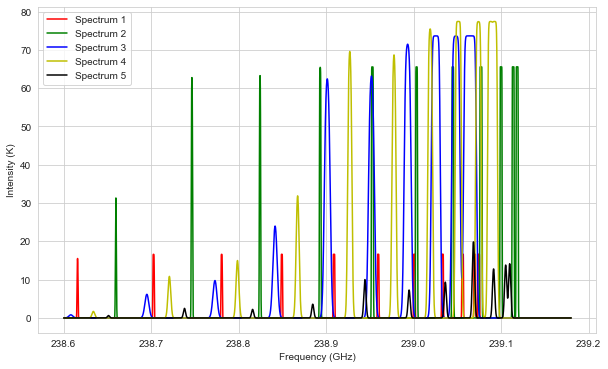

In [14]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

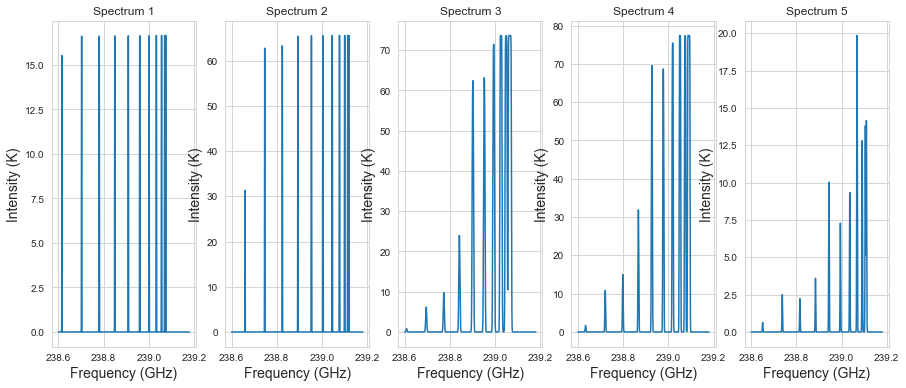

In [15]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [16]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [17]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 907))
approx_coeffs = np.zeros((len(signal), 907))
level = 6
wname = 'coif6'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [18]:
feature_vector.shape

(10000, 58000)

In [19]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
0          238.60000        0.0
1          238.60001        0.0
2          238.60002        0.0
3          238.60003        0.0
4          238.60004        0.0
...              ...        ...
579999995  239.17995        0.0
579999996  239.17996        0.0
579999997  239.17997        0.0
579999998  239.17998        0.0
579999999  239.17999        0.0

[580000000 rows x 2 columns]

In [20]:
detail_coeffs.shape
detail_coeffs

array([[ 0.00000000e+00,  0.00000000e+00, -4.05207595e-55, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.37555489e-03,  3.05787865e-04, -1.77440358e-04, ...,
         1.85245870e-04, -1.96502555e-04,  2.24139576e-03],
       ...,
       [ 6.73892699e+01, -1.38557138e+01,  9.99737602e+00, ...,
        -1.26807965e+01,  1.93295337e+01, -1.53218596e+02],
       [-2.78550665e-18,  5.28012561e-19, -7.49363132e-20, ...,
         1.37992392e-16, -4.38303914e-17,  1.12741106e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [21]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [22]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [23]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [24]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [25]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [26]:
# len(signal)

approx_coeffs.shape

(10000, 907)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [27]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

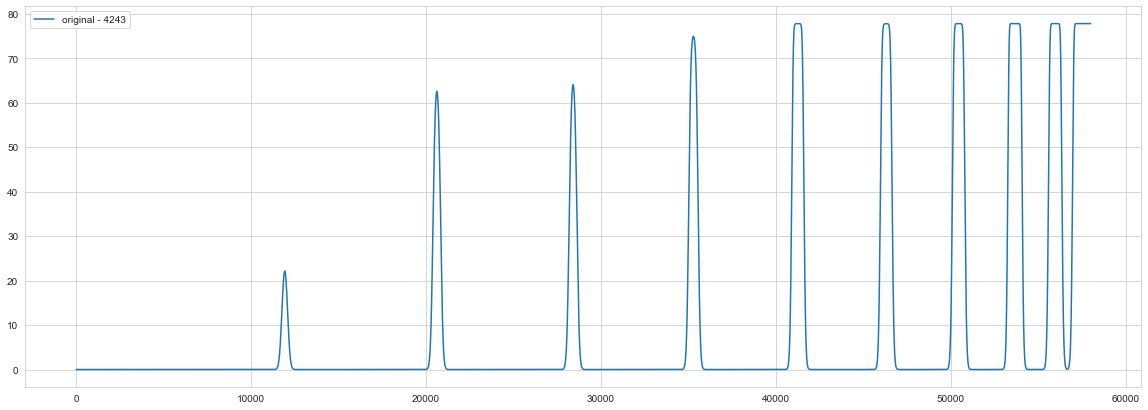

In [28]:
plt.figure(figsize=(20,7))
plt.plot(signal[4243], label='original - 4243')
plt.legend()
plt.savefig("data/10K_gen_files/original.png")
plt.show()

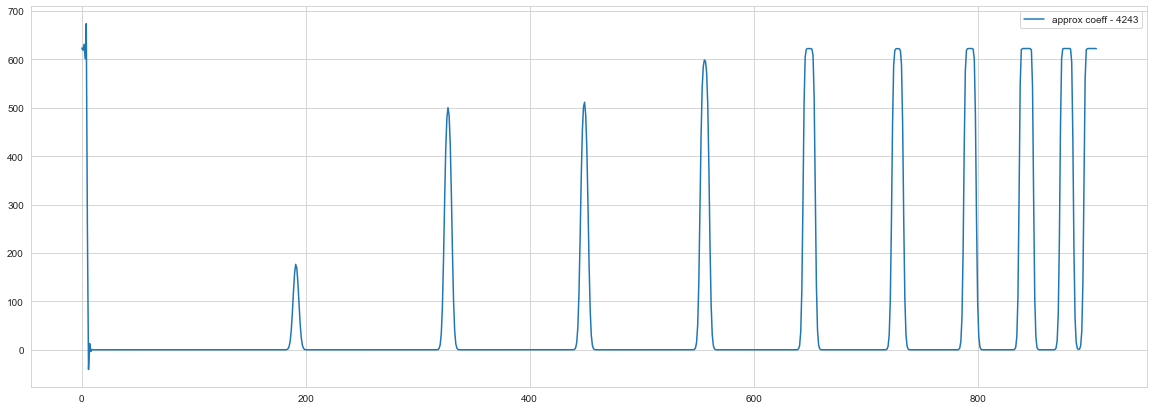

In [29]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[4243], label='approx coeff - 4243')
plt.legend()
plt.savefig("data/10K_gen_files/approx_level6.png")
plt.show()

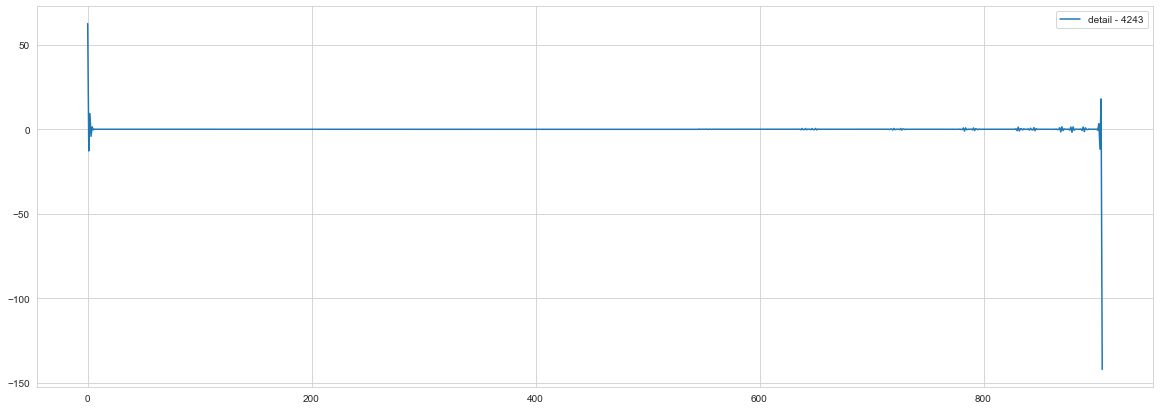

In [30]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[4243], label='detail - 4243')
plt.legend()
plt.savefig("data/10K_gen_files/detail_level6.png")
plt.show()

In [31]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (10000, 907) labels_shape:  (10000, 6)


In [32]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

#### save the true params to a file

In [33]:
# get the last 3000 data of the parameters from labels 
df_param = df_param.iloc[-3000:, :]
# save the vals to a csv file
df_param.to_csv("data/10K_gen_files/true_param_vals.csv")
df_param.head()


A         fwhm          ntot      size         tex        vlsr
g                                                             
7000  8.277957  3.547592e+17  1.224458  288.842953   99.263494
7001  5.022305  3.637225e+17  1.638663  167.839263   60.218975
7002  2.712427  3.635302e+17  1.750680  201.175288 -106.634146
7003  8.666178  5.381971e+16  0.664417   11.992266 -105.522675
7004  4.453063  1.146947e+17  0.455909  246.051514  -80.721674

In [34]:
df = pd.DataFrame(approx_coeffs)
df.head()

0         1             2             3             4             5    \
0  0.000000  0.000000 -4.236853e-59 -1.700942e-46 -5.867105e-42 -1.131871e-35   
1  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2 -0.000017  0.000051 -1.355962e-04  3.613813e-04 -9.806227e-04  8.090383e-03   
3  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            6             7             8             9    ...           897  \
0 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21  ...  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
2  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01  ...  1.052277e-15   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   

            898           899           900           901           902  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  2.094833e-13 -3.639334e-12  3.274123e-11 -3.293064e-10  3.818465e-09   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

            903           904       905       906  
0  0.000000e+00  0.000000e+00  0.000000  0.000000  
1  0.000000e+00  0.000000e+00  0.000000  0.000000  
2 -3.575151e-08  2.488638e-07 -0.000001  0.000005  
3  0.000000e+00  0.000000e+00  0.000000  0.000000  
4  0.000000e+00  0.000000e+00  0.000000  0.000000  

[5 rows x 907 columns]

In [35]:
df = pd.concat([df, labels_], axis=1)
df.head()

0         1             2             3             4             5  \
0  0.000000  0.000000 -4.236853e-59 -1.700942e-46 -5.867105e-42 -1.131871e-35   
1  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2 -0.000017  0.000051 -1.355962e-04  3.613813e-04 -9.806227e-04  8.090383e-03   
3  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              6             7             8             9  ...           902  \
0 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21  ...  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
2  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01  ...  3.818465e-09   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   

            903           904       905       906      fwhm          ntot  \
0  0.000000e+00  0.000000e+00  0.000000  0.000000  1.104218  5.888377e+17   
1  0.000000e+00  0.000000e+00  0.000000  0.000000  1.311138  2.510638e+17   
2 -3.575151e-08  2.488638e-07 -0.000001  0.000005  6.637987  7.819653e+16   
3  0.000000e+00  0.000000e+00  0.000000  0.000000  4.578995  6.434423e+16   
4  0.000000e+00  0.000000e+00  0.000000  0.000000  3.581212  1.328970e+16   

       size         tex       vlsr  
0  0.365643  392.967603  79.658791  
1  1.193705  209.445129  24.579956  
2  1.493372  120.944377  89.281443  
3  1.694034  139.142766  56.959016  
4  0.798906  301.743569  35.268285  

[5 rows x 912 columns]

In [36]:
df.shape

(10000, 912)

In [37]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

0         1             2             3             4             5  \
0  0.000000  0.000000 -4.236853e-59 -1.700942e-46 -5.867105e-42 -1.131871e-35   
1  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2 -0.000017  0.000051 -1.355962e-04  3.613813e-04 -9.806227e-04  8.090383e-03   
3  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              6             7             8             9  ...           902  \
0 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21  ...  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
2  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01  ...  3.818465e-09   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   
4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...  0.000000e+00   

            903           904       905       906      fwhm       ntot  \
0  0.000000e+00  0.000000e+00  0.000000  0.000000  1.104218  17.769996   
1  0.000000e+00  0.000000e+00  0.000000  0.000000  1.311138  17.399784   
2 -3.575151e-08  2.488638e-07 -0.000001  0.000005  6.637987  16.893187   
3  0.000000e+00  0.000000e+00  0.000000  0.000000  4.578995  16.808510   
4  0.000000e+00  0.000000e+00  0.000000  0.000000  3.581212  16.123515   

       size         tex       vlsr  
0  0.365643  392.967603  79.658791  
1  1.193705  209.445129  24.579956  
2  1.493372  120.944377  89.281443  
3  1.694034  139.142766  56.959016  
4  0.798906  301.743569  35.268285  

[5 rows x 912 columns]

In [38]:
X = df.iloc[:, :907]
y = df.iloc[:, -5:]

In [39]:
X

0             1             2             3             4    \
0     0.000000e+00  0.000000e+00 -4.236853e-59 -1.700942e-46 -5.867105e-42   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -1.724022e-05  5.141306e-05 -1.355962e-04  3.613813e-04 -9.806227e-04   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.483805e+01  1.316246e+02  2.469955e+02  3.881978e+02  5.602747e+02   
9997  6.718953e+02  6.672227e+02  6.800508e+02  6.479492e+02  7.263756e+02   
9998  1.148500e-15 -3.537846e-16  1.280122e-16 -2.419984e-17  3.133399e-18   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               5             6             7             8             9    \
0    -1.131871e-35 -1.579997e-31 -1.709550e-30 -1.828596e-26  1.478300e-21   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     8.090383e-03  3.189991e-02  7.606479e-02  1.717340e-01  3.561268e-01   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  2.249120e+02 -3.691602e+01  1.175815e+01 -3.336094e+00  6.966394e-01   
9997  2.713875e+02 -4.388532e+01  1.393161e+01 -3.957500e+00  8.294872e-01   
9998 -5.876214e-20 -3.203194e-21 -9.453978e-23  5.576446e-24 -4.530599e-26   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...           897           898           899           900  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  1.052277e-15  2.094833e-13 -3.639334e-12  3.274123e-11   
3     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...   ...           ...           ...           ...           ...   
9995  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  ... -2.780397e-07 -1.031602e-07 -1.416790e-05  2.598835e-04   
9997  ...  5.672248e+01  1.092920e+02  1.931781e+02  3.082920e+02   
9998  ...  1.154071e-07  2.313461e-08  4.406776e-09  7.979096e-10   
9999  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               901           902           903           904           905  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2    -3.293064e-10  3.818465e-09 -3.575151e-08  2.488638e-07 -1.295111e-06   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996 -2.575486e-03  1.663722e-02 -7.461142e-02  2.825404e-01 -3.921728e-01   
9997  4.379222e+02  5.513437e+02  6.243567e+02  6.574841e+02  6.680301e+02   
9998  1.374098e-10  2.252140e-11  3.522056e-12  5.235008e-13  7.464218e-14   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               906  
0     0.000000e+00  
1     0.000000e+00  
2     5.193909e-06  
3     0.000000e+00  
4     0.000000e+00  
...            ...  
9995  0.000000e+00  
9996  5.658809e+00  
9997  6.699943e+02  
9998 -8.461201e-16  
9999  0.000000e+00  

[10000 rows x 907 columns]

In [40]:
y

fwhm       ntot      size         tex        vlsr
0     1.104218  17.769996  0.365643  392.967603   79.658791
1     1.311138  17.399784  1.193705  209.445129   24.579956
2     6.637987  16.893187  1.493372  120.944377   89.281443
3     4.578995  16.808510  1.694034  139.142766   56.959016
4     3.581212  16.123515  0.798906  301.743569   35.268285
...        ...        ...       ...         ...         ...
9995  3.510950  16.946165  2.287943   20.132487   57.424608
9996  2.907827  16.882800  1.929440  362.118917  -75.890725
9997  8.238700  17.897499  2.244999  330.387721 -104.401538
9998  8.326096  16.379398  1.970493   72.088183  -16.738557
9999  1.189584  17.890535  1.553216  340.288271   52.182076

[10000 rows x 5 columns]

#### split the data into the training and test set

In [41]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=False,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (7000, 907) 
 y_train shape:  (7000, 5) 
 X_test shape:  (3000, 907) 
 y_test shape:  (3000, 5)


## 1. Multioutput Regressor - RF

In [42]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))

# # from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=42
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 2 of 700
building tree 1 of 700
building tree 4 of 700building tree 8 of 700
building tree 6 of 700
building tree 5 of 700
building tree 7 of 700

building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 15 of 700
building tree 13 of 700
building tree 12 of 700
building tree 16 of 700
building tree 14 of 700
building tree 18 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 20 of 700
building tree 22 of 700
building tree 23 of 700
building tree 24 of 700
building tree 25 of 700
building tree 26 of 700
building tree 27 of 700


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s


building tree 29 of 700
building tree 28 of 700
building tree 30 of 700
building tree 33 of 700
building tree 31 of 700
building tree 32 of 700
building tree 35 of 700
building tree 34 of 700
building tree 36 of 700
building tree 37 of 700
building tree 39 of 700
building tree 38 of 700
building tree 40 of 700
building tree 41 of 700
building tree 43 of 700
building tree 44 of 700
building tree 42 of 700
building tree 45 of 700
building tree 46 of 700
building tree 47 of 700
building tree 49 of 700building tree 48 of 700

building tree 50 of 700
building tree 54 of 700
building tree 53 of 700
building tree 51 of 700
building tree 52 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 61 of 700
building tree 58 of 700
building tree 63 of 700
building tree 59 of 700
building tree 62 of 700
building tree 60 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.2s


building tree 315 of 700
building tree 321 of 700
building tree 325 of 700
building tree 329 of 700
building tree 318 of 700
building tree 333 of 700
building tree 316 of 700
building tree 337 of 700
building tree 341 of 700
building tree 322 of 700
building tree 319 of 700
building tree 330 of 700
building tree 326 of 700
building tree 334 of 700
building tree 338 of 700
building tree 323 of 700
building tree 327 of 700
building tree 342 of 700
building tree 345 of 700
building tree 331 of 700
building tree 320 of 700
building tree 335 of 700
building tree 339 of 700
building tree 324 of 700
building tree 343 of 700
building tree 328 of 700
building tree 332 of 700
building tree 346 of 700
building tree 336 of 700
building tree 340 of 700
building tree 344 of 700
building tree 349 of 700
building tree 353 of 700
building tree 347 of 700
building tree 357 of 700
building tree 361 of 700
building tree 348 of 700
building tree 350 of 700
building tree 365 of 700
building tree 354 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 4 of 700building tree 2 of 700

building tree 3 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 28 of 700
building tree 22 of 700
building tree 24 of 700
building tree 20 of 700
building tree 18 of 700
building tree 26 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 36 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s


building tree 61 of 700
building tree 50 of 700
building tree 63 of 700
building tree 54 of 700
building tree 52 of 700
building tree 60 of 700
building tree 56 of 700
building tree 58 of 700
building tree 62 of 700
building tree 64 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 66 of 700
building tree 68 of 700
building tree 73 of 700
building tree 75 of 700
building tree 71 of 700
building tree 70 of 700
building tree 77 of 700
building tree 79 of 700
building tree 72 of 700
building tree 76 of 700
building tree 74 of 700
building tree 78 of 700
building tree 83 of 700
building tree 80 of 700
building tree 85 of 700
building tree 81 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 86 of 700
building tree 84 of 700
building tree 82 of 700
building tree 93 of 700
building tree 95 of 700
building tree 90 of 700
building tree 88 of 700
building tree 92 of 700
building tree 97 of 700
building tree 99

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.3s


building tree 305 of 700
building tree 296 of 700
building tree 307 of 700
building tree 298 of 700
building tree 300 of 700
building tree 309 of 700
building tree 302 of 700
building tree 304 of 700
building tree 306 of 700
building tree 308 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 310 of 700
building tree 317 of 700
building tree 319 of 700
building tree 321 of 700
building tree 314 of 700
building tree 312 of 700
building tree 316 of 700
building tree 323 of 700
building tree 322 of 700
building tree 318 of 700
building tree 325 of 700
building tree 320 of 700
building tree 324 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 326 of 700
building tree 333 of 700
building tree 335 of 700
building tree 337 of 700
building tree 328 of 700
building tree 330 of 700
building tree 334 of 700
building tree 332 of 700
building tree 336 of 700
building tree 339 of 700
building tree 341 of 700


[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   11.2s finished


building tree 693 of 700
building tree 694 of 700
building tree 695 of 700
building tree 696 of 700
building tree 697 of 700
building tree 698 of 700
building tree 699 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 3 of 700
building tree 2 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 22 of 700
building tree 18 of 700
building tree 24 of 700
building tree 26 of 700
building tree 28 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s


building tree 49 of 700
building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 50 of 700
building tree 52 of 700
building tree 60 of 700
building tree 56 of 700
building tree 58 of 700
building tree 62 of 700
building tree 54 of 700
building tree 64 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 70 of 700
building tree 68 of 700
building tree 66 of 700
building tree 74 of 700
building tree 72 of 700
building tree 76 of 700
building tree 78 of 700
building tree 80 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 95 of 700
building tree 84 of 700
building tree 82

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.5s


building tree 303 of 700
building tree 290 of 700
building tree 292 of 700
building tree 294 of 700
building tree 300 of 700
building tree 298 of 700
building tree 296 of 700
building tree 302 of 700
building tree 304 of 700
building tree 305 of 700
building tree 307 of 700
building tree 309 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 317 of 700
building tree 306 of 700
building tree 319 of 700
building tree 312 of 700
building tree 308 of 700
building tree 310 of 700
building tree 316 of 700
building tree 314 of 700
building tree 318 of 700
building tree 320 of 700
building tree 321 of 700
building tree 323 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 333 of 700
building tree 335 of 700
building tree 324 of 700
building tree 322 of 700
building tree 326 of 700
building tree 332 of 700
building tree 328 of 700
building tree 330 of 700
building tree 334 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:   11.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 3 of 700
building tree 4 of 700
building tree 2 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 24 of 700
building tree 22 of 700
building tree 26 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 34 of 700
building tree 36 of 700
building tree 38 of 700


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s


building tree 40 of 700
building tree 43 of 700
building tree 41 of 700
building tree 45 of 700
building tree 47 of 700
building tree 44 of 700
building tree 42 of 700
building tree 46 of 700
building tree 48 of 700
building tree 49 of 700
building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 52 of 700
building tree 50 of 700
building tree 57 of 700
building tree 56 of 700
building tree 54 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 58 of 700
building tree 60 of 700
building tree 65 of 700
building tree 62 of 700
building tree 64 of 700
building tree 66 of 700
building tree 69 of 700
building tree 67 of 700
building tree 71 of 700
building tree 70 of 700
building tree 68 of 700
building tree 72 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700building tree 81 of 700

building tree 74 of 700
building tree 76 of 700
building tree 78 of 700
building tree 83

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s


building tree 301 of 700
building tree 303 of 700
building tree 305 of 700
building tree 307 of 700
building tree 309 of 700
building tree 298 of 700
building tree 311 of 700
building tree 300 of 700
building tree 302 of 700
building tree 304 of 700
building tree 308 of 700
building tree 306 of 700
building tree 310 of 700
building tree 312 of 700
building tree 313 of 700
building tree 315 of 700
building tree 317 of 700
building tree 319 of 700
building tree 321 of 700
building tree 323 of 700
building tree 325 of 700
building tree 316 of 700
building tree 314 of 700
building tree 322 of 700
building tree 318 of 700
building tree 320 of 700
building tree 327 of 700
building tree 324 of 700
building tree 326 of 700
building tree 328 of 700
building tree 329 of 700
building tree 333 of 700
building tree 331 of 700
building tree 335 of 700
building tree 337 of 700
building tree 339 of 700
building tree 341 of 700
building tree 330 of 700
building tree 332 of 700
building tree 334 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    7.5s finished


building tree 694 of 700
building tree 695 of 700
building tree 696 of 700
building tree 697 of 700
building tree 699 of 700
building tree 698 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 2 of 700
building tree 7 of 700
building tree 4 of 700
building tree 1 of 700
building tree 6 of 700building tree 5 of 700

building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 18 of 700
building tree 20 of 700
building tree 24 of 700
building tree 22 of 700
building tree 25 of 700
building tree 27 of 700
building tree 26 of 700
building tree 28 of 700
building tree 31 of 700building tree 29 of 700

building tree 35 of 700
building tree 33 of 700
building tree 39 of 700
building tree 37 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 38 of 700
building tree 36 of 700
building tree 32 of 700
building tree 30 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s


building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 46 of 700
building tree 50 of 700
building tree 48 of 700
building tree 52 of 700
building tree 54 of 700
building tree 56 of 700
building tree 59 of 700
building tree 58 of 700
building tree 61 of 700
building tree 63 of 700
building tree 65 of 700
building tree 60 of 700
building tree 67 of 700
building tree 69 of 700
building tree 62 of 700
building tree 71 of 700
building tree 64 of 700
building tree 66 of 700
building tree 73 of 700
building tree 68 of 700
building tree 75 of 700
building tree 70 of 700
building tree 72 of 700
building tree 77 of 700
building tree 74 of 700
building tree 76 of 700
building tree 79 of 700
building tree 78 of 700
building tree 83 of 700
building tree 81 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 80 of 700
building tree 84 of 700
building tree 82 of 700
building tree 86 of 700
building tree 93

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s


building tree 289 of 700
building tree 291 of 700
building tree 288 of 700
building tree 290 of 700
building tree 293 of 700
building tree 292 of 700
building tree 295 of 700
building tree 297 of 700
building tree 299 of 700
building tree 301 of 700
building tree 303 of 700
building tree 305 of 700
building tree 294 of 700
building tree 307 of 700
building tree 296 of 700
building tree 298 of 700
building tree 300 of 700
building tree 302 of 700
building tree 309 of 700
building tree 304 of 700
building tree 306 of 700
building tree 308 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 310 of 700
building tree 317 of 700
building tree 314 of 700
building tree 312 of 700
building tree 316 of 700
building tree 318 of 700
building tree 319 of 700
building tree 321 of 700
building tree 323 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 333 of 700
building tree 322 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    6.8s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [43]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(

In [44]:
regr_multirf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

0.7565061392011836

### save the predicted parameters to a csv file 

In [45]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm_rf_pred', 'ntot_rf_pred', 'size_rf_pred', 'tex_rf_pred', 'vlsr_rf_pred'], index=X_test.index)
param_df_rf.head()

fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  vlsr_rf_pred
7000      8.514918     17.522661      1.368975   252.417090     99.444558
7001      5.106843     17.471298      1.748936   215.785916     59.963337
7002      2.964240     17.348980      1.831523   209.045707   -103.095206
7003      6.463369     16.701025      1.473673    14.420086    -97.611904
7004      4.297959     16.779588      0.744671   237.145995    -80.550190

In [46]:
# convert back the log to linear values 
param_df_rf['ntot_rf_pred'] = np.array(10**param_df_rf['ntot_rf_pred'])

In [47]:
param_df_rf.to_csv('data/10K_gen_files/predicted_parameters_rf.csv', index=True)
param_df_rf.shape

(3000, 5)

In [48]:
pred_para = pd.read_csv('data/10K_gen_files/predicted_parameters_rf.csv')
true_para = pd.read_csv('data/10K_gen_files/true_param_vals.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv('data/10K_gen_files/true_param_vals_with_predicted_rf.csv')
true_para.head()

g      fwhm          ntot      size         tex        vlsr    0  \
0  7000  8.277957  3.547592e+17  1.224458  288.842953   99.263494  0.0   
1  7001  5.022305  3.637225e+17  1.638663  167.839263   60.218975  0.0   
2  7002  2.712427  3.635302e+17  1.750680  201.175288 -106.634146  0.0   
3  7003  8.666178  5.381971e+16  0.664417   11.992266 -105.522675  0.0   
4  7004  4.453063  1.146947e+17  0.455909  246.051514  -80.721674  0.0   

   Unnamed: 0  fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  \
0        7000      8.514918  3.331663e+17      1.368975   252.417090   
1        7001      5.106843  2.960043e+17      1.748936   215.785916   
2        7002      2.964240  2.233468e+17      1.831523   209.045707   
3        7003      6.463369  5.023718e+16      1.473673    14.420086   
4        7004      4.297959  6.019880e+16      0.744671   237.145995   

   vlsr_rf_pred  
0     99.444558  
1     59.963337  
2   -103.095206  
3    -97.611904  
4    -80.550190

#### Metrics

In [49]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))


In [50]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  11.439557422227429
Multirf  mse:  914.5546634408013
Multirf  rmse:  30.241604842349243
Multirf  mape:  fwhm     9.247356
ntot     1.693900
size    38.652409
tex     37.062470
vlsr     3.680982
dtype: float64
Multirf  r2:  0.7565061392011836
Multirf  msle:  30.241604842349243


### Predicted vs True values plots

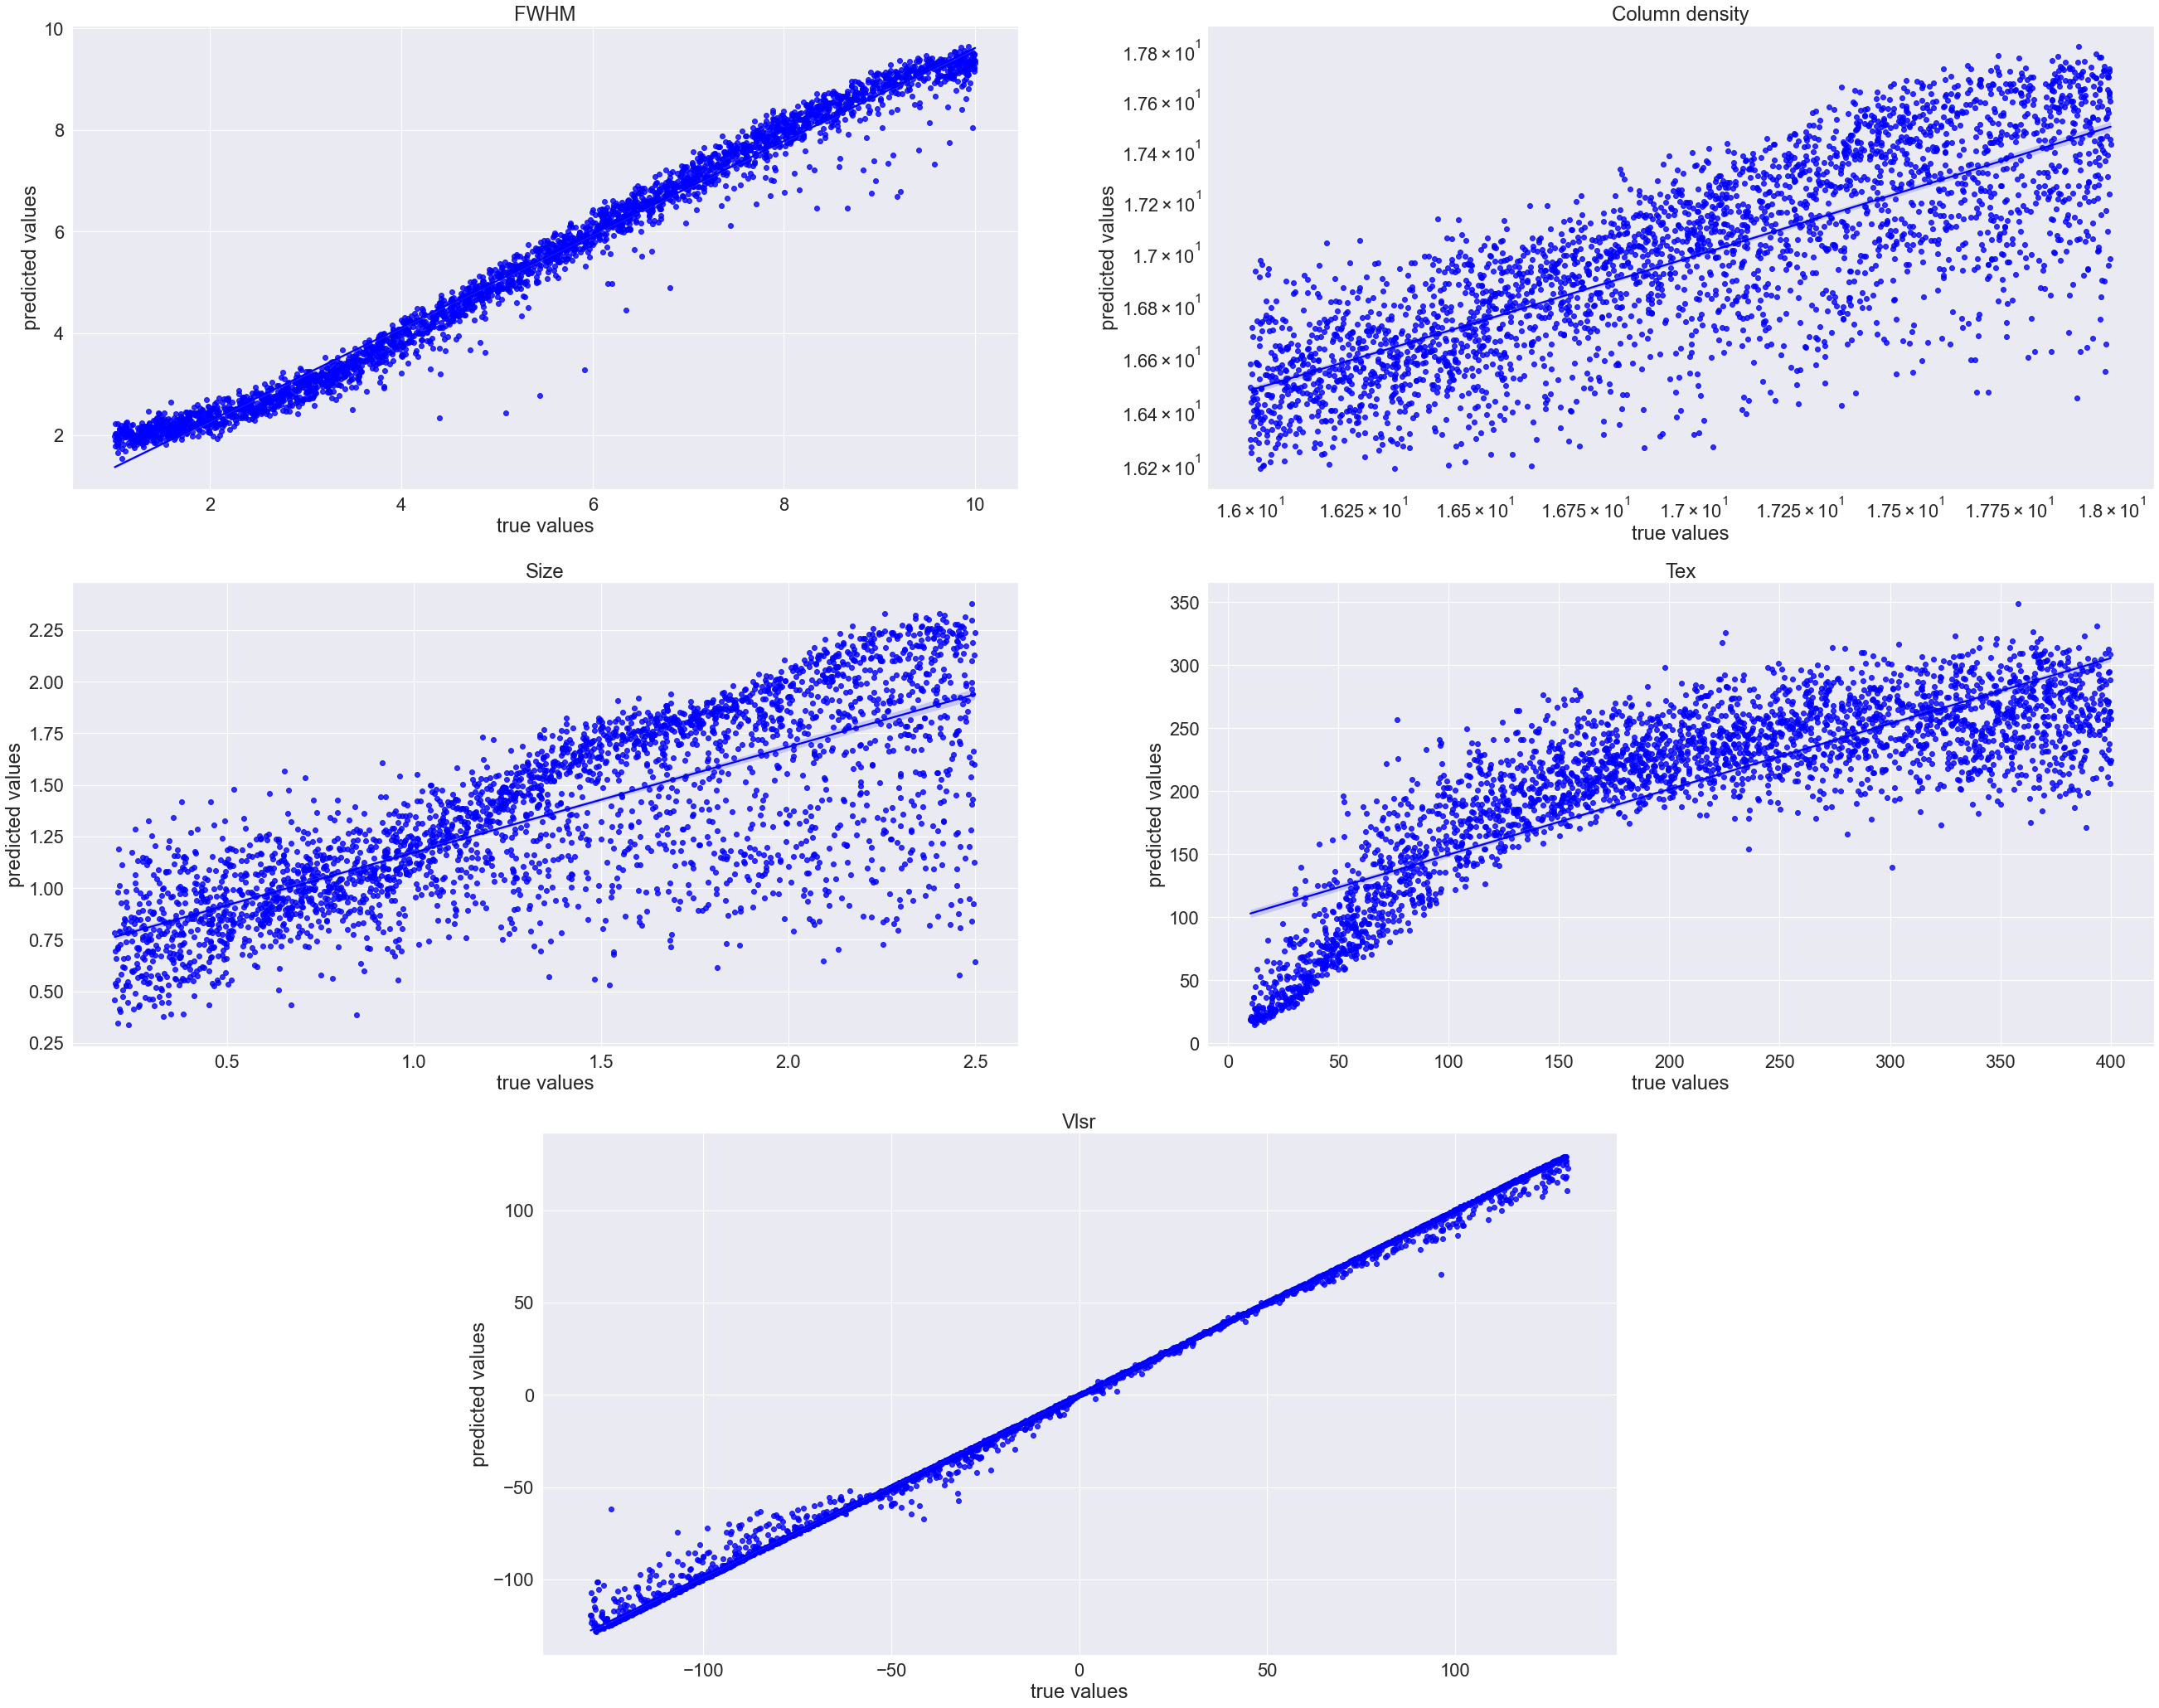

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_RF.png")
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [55]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf.head()

fwhm       ntot      size         tex        vlsr
0  8.514918  17.522661  1.368975  252.417090   99.444558
1  5.106843  17.471298  1.748936  215.785916   59.963337
2  2.964240  17.348980  1.831523  209.045707 -103.095206
3  6.463369  16.701025  1.473673   14.420086  -97.611904
4  4.297959  16.779588  0.744671  237.145995  -80.550190

### Residuals 3D plot -  Random Forest Regressor

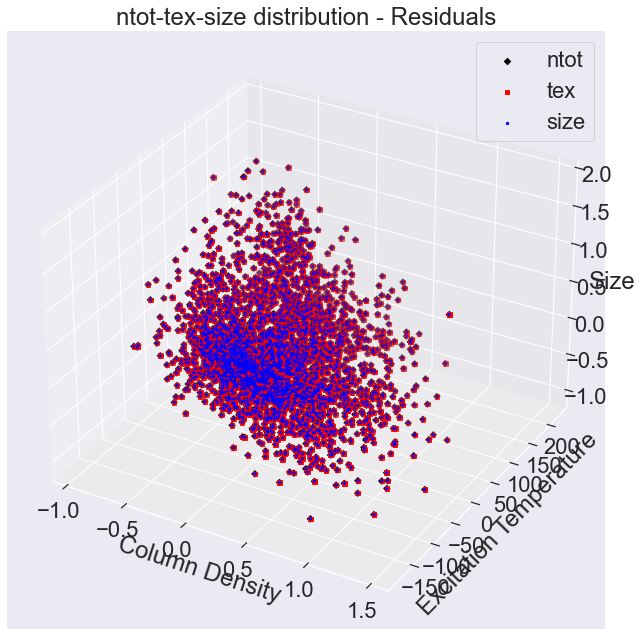

In [56]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

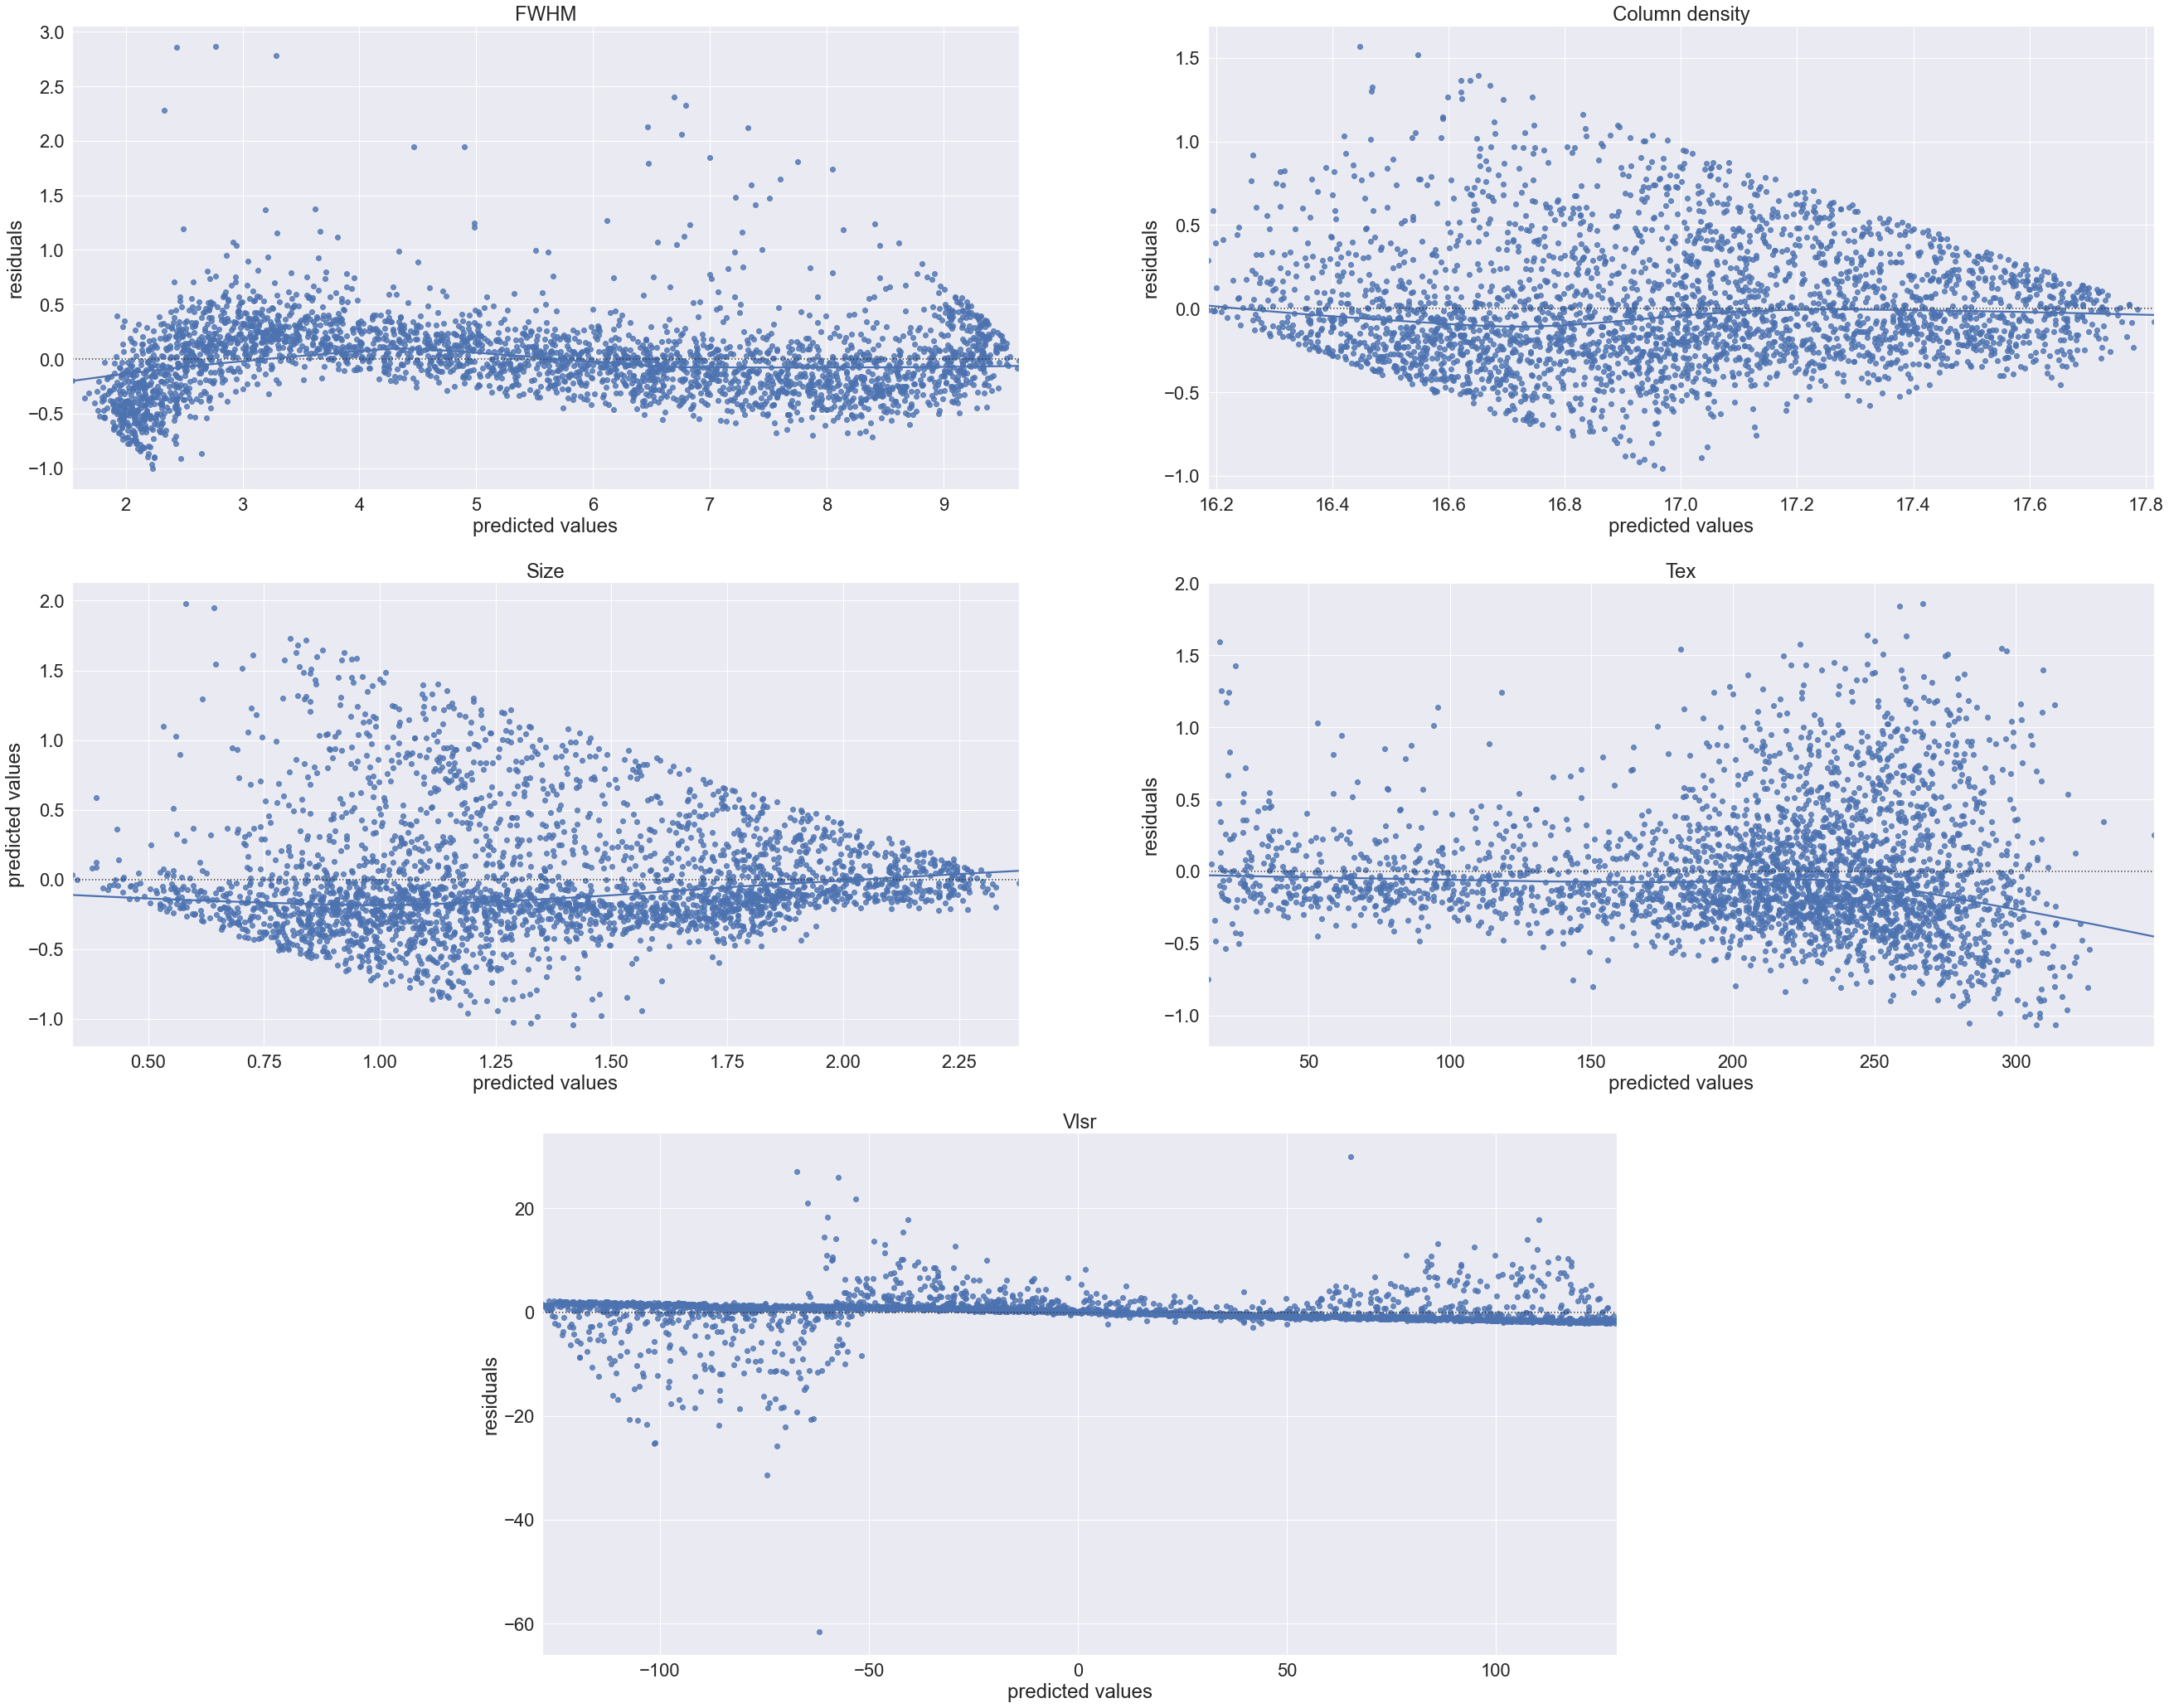

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_RF_10K.png")
plt.show()

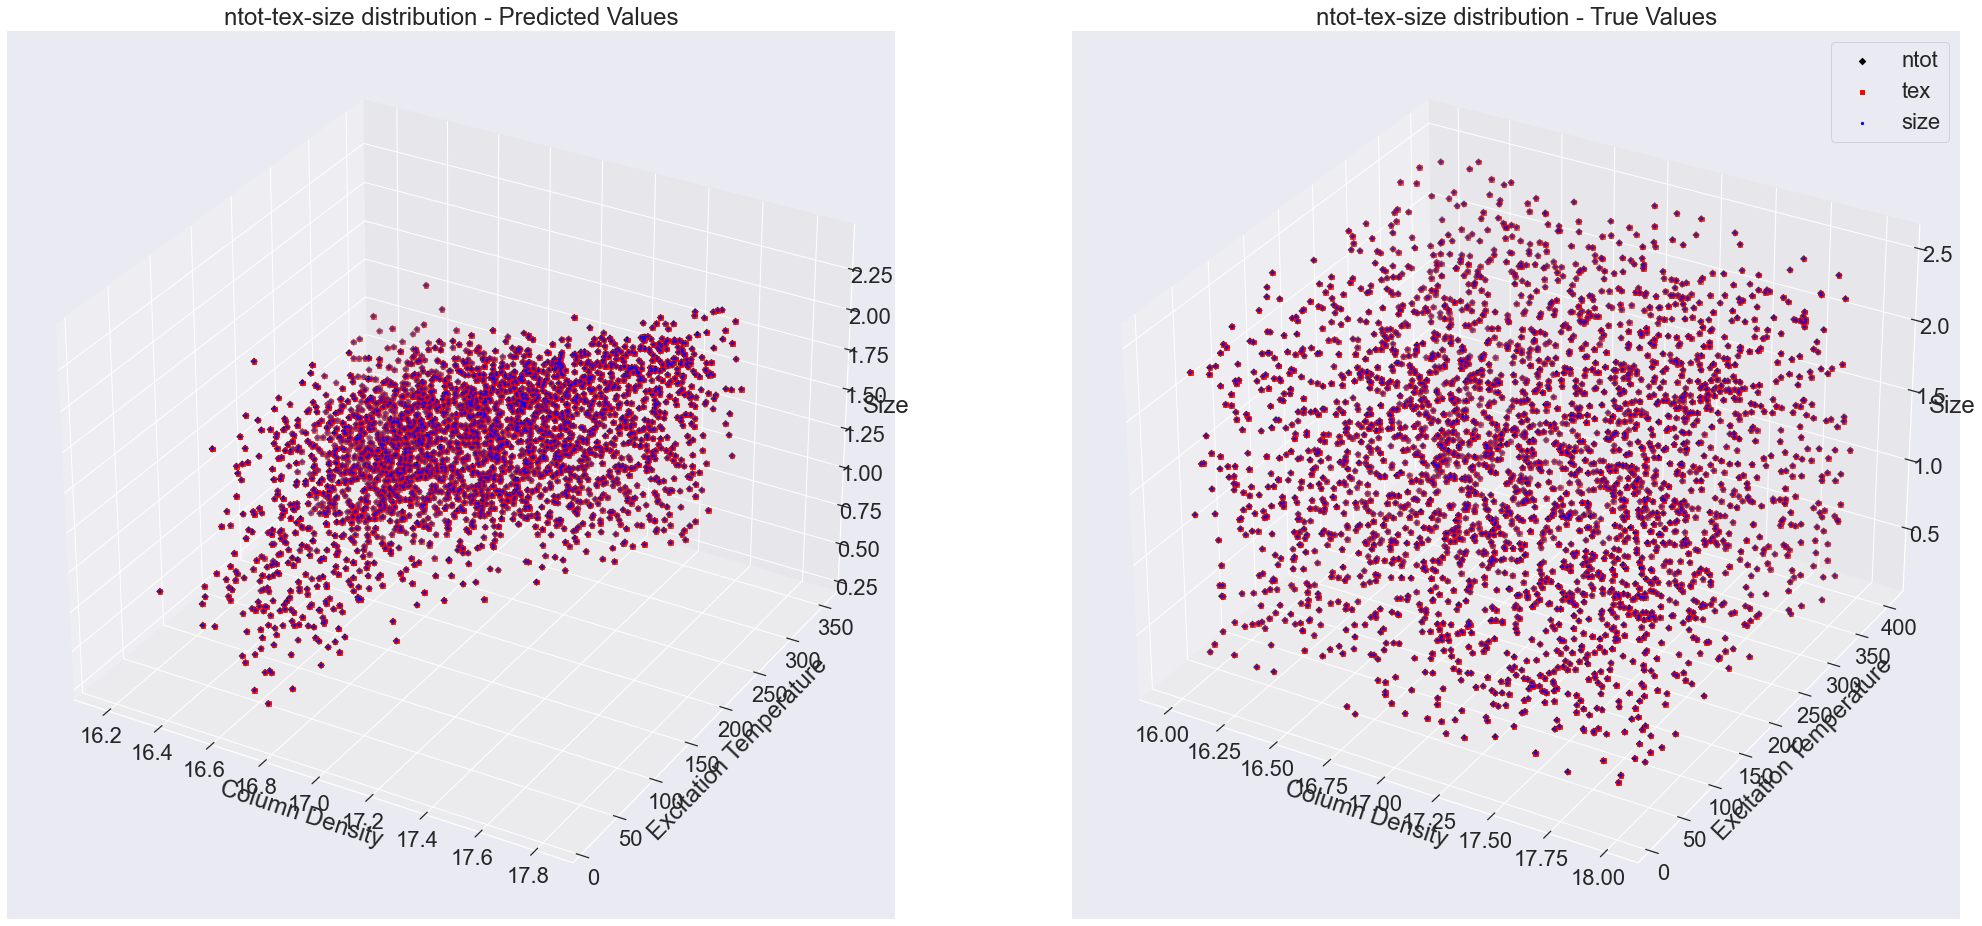

In [58]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/10K_gen_files/scatter3D_pred_true_10K_RF.png")
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [59]:
multirf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        criterion="squared_error",
        bootstrap=True,
        n_jobs=-1,
        max_samples=None,
))

multrf_hyperparameters = dict(
    estimator__n_estimators=np.arange(100, 1000, 100),
    estimator__max_depth=np.arange(10, 150, 10),
    estimator__min_samples_split=np.arange(2, 10, 2),
    estimator__min_samples_leaf=np.arange(1, 5, 1),
    # estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
    # estimator__criterion=["squared_error", "absolute_error"],
    estimator__max_features=["auto", "sqrt", "log2"],
    # estimator__max_samples=np.arange(0.5, 1, 0.1),
    estimator__bootstrap=["True", "False"]
    )

In [60]:
random_search = RandomizedSearchCV(
    estimator=multirf_model,
    param_distributions=multrf_hyperparameters,
    n_iter=100,
    cv=5,
    verbose=2,
    error_score="raise",
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

In [61]:
# best parameters from tuned model
regr_tuned_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
       n_estimators=800, 
       min_samples_split=2,
       min_samples_leaf=1,
       max_features='auto', 
       max_depth=130,
       bootstrap=True,
       verbose=5
    )
)

In [62]:
hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.5s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 32.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.3s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 71.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.3s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.5s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 79.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 39.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.5s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.6s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 29.0min finished


In [63]:
y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

In [69]:
# # TODO: interpret the model evaluation metrics
eval = RegressionMetrics()
for metric in _metrics:
    print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

mae : 9.235994018261797
mse : 668.3755991879931
rmse : 25.8529611299749
mape : fwhm     8.009632
ntot     1.588421
size    32.677189
tex     26.736405
vlsr     5.338775
dtype: float64
r2 : 0.8000499284488845
msle : 25.8529611299749


### True vs Predicted Values - RF Tuned Model

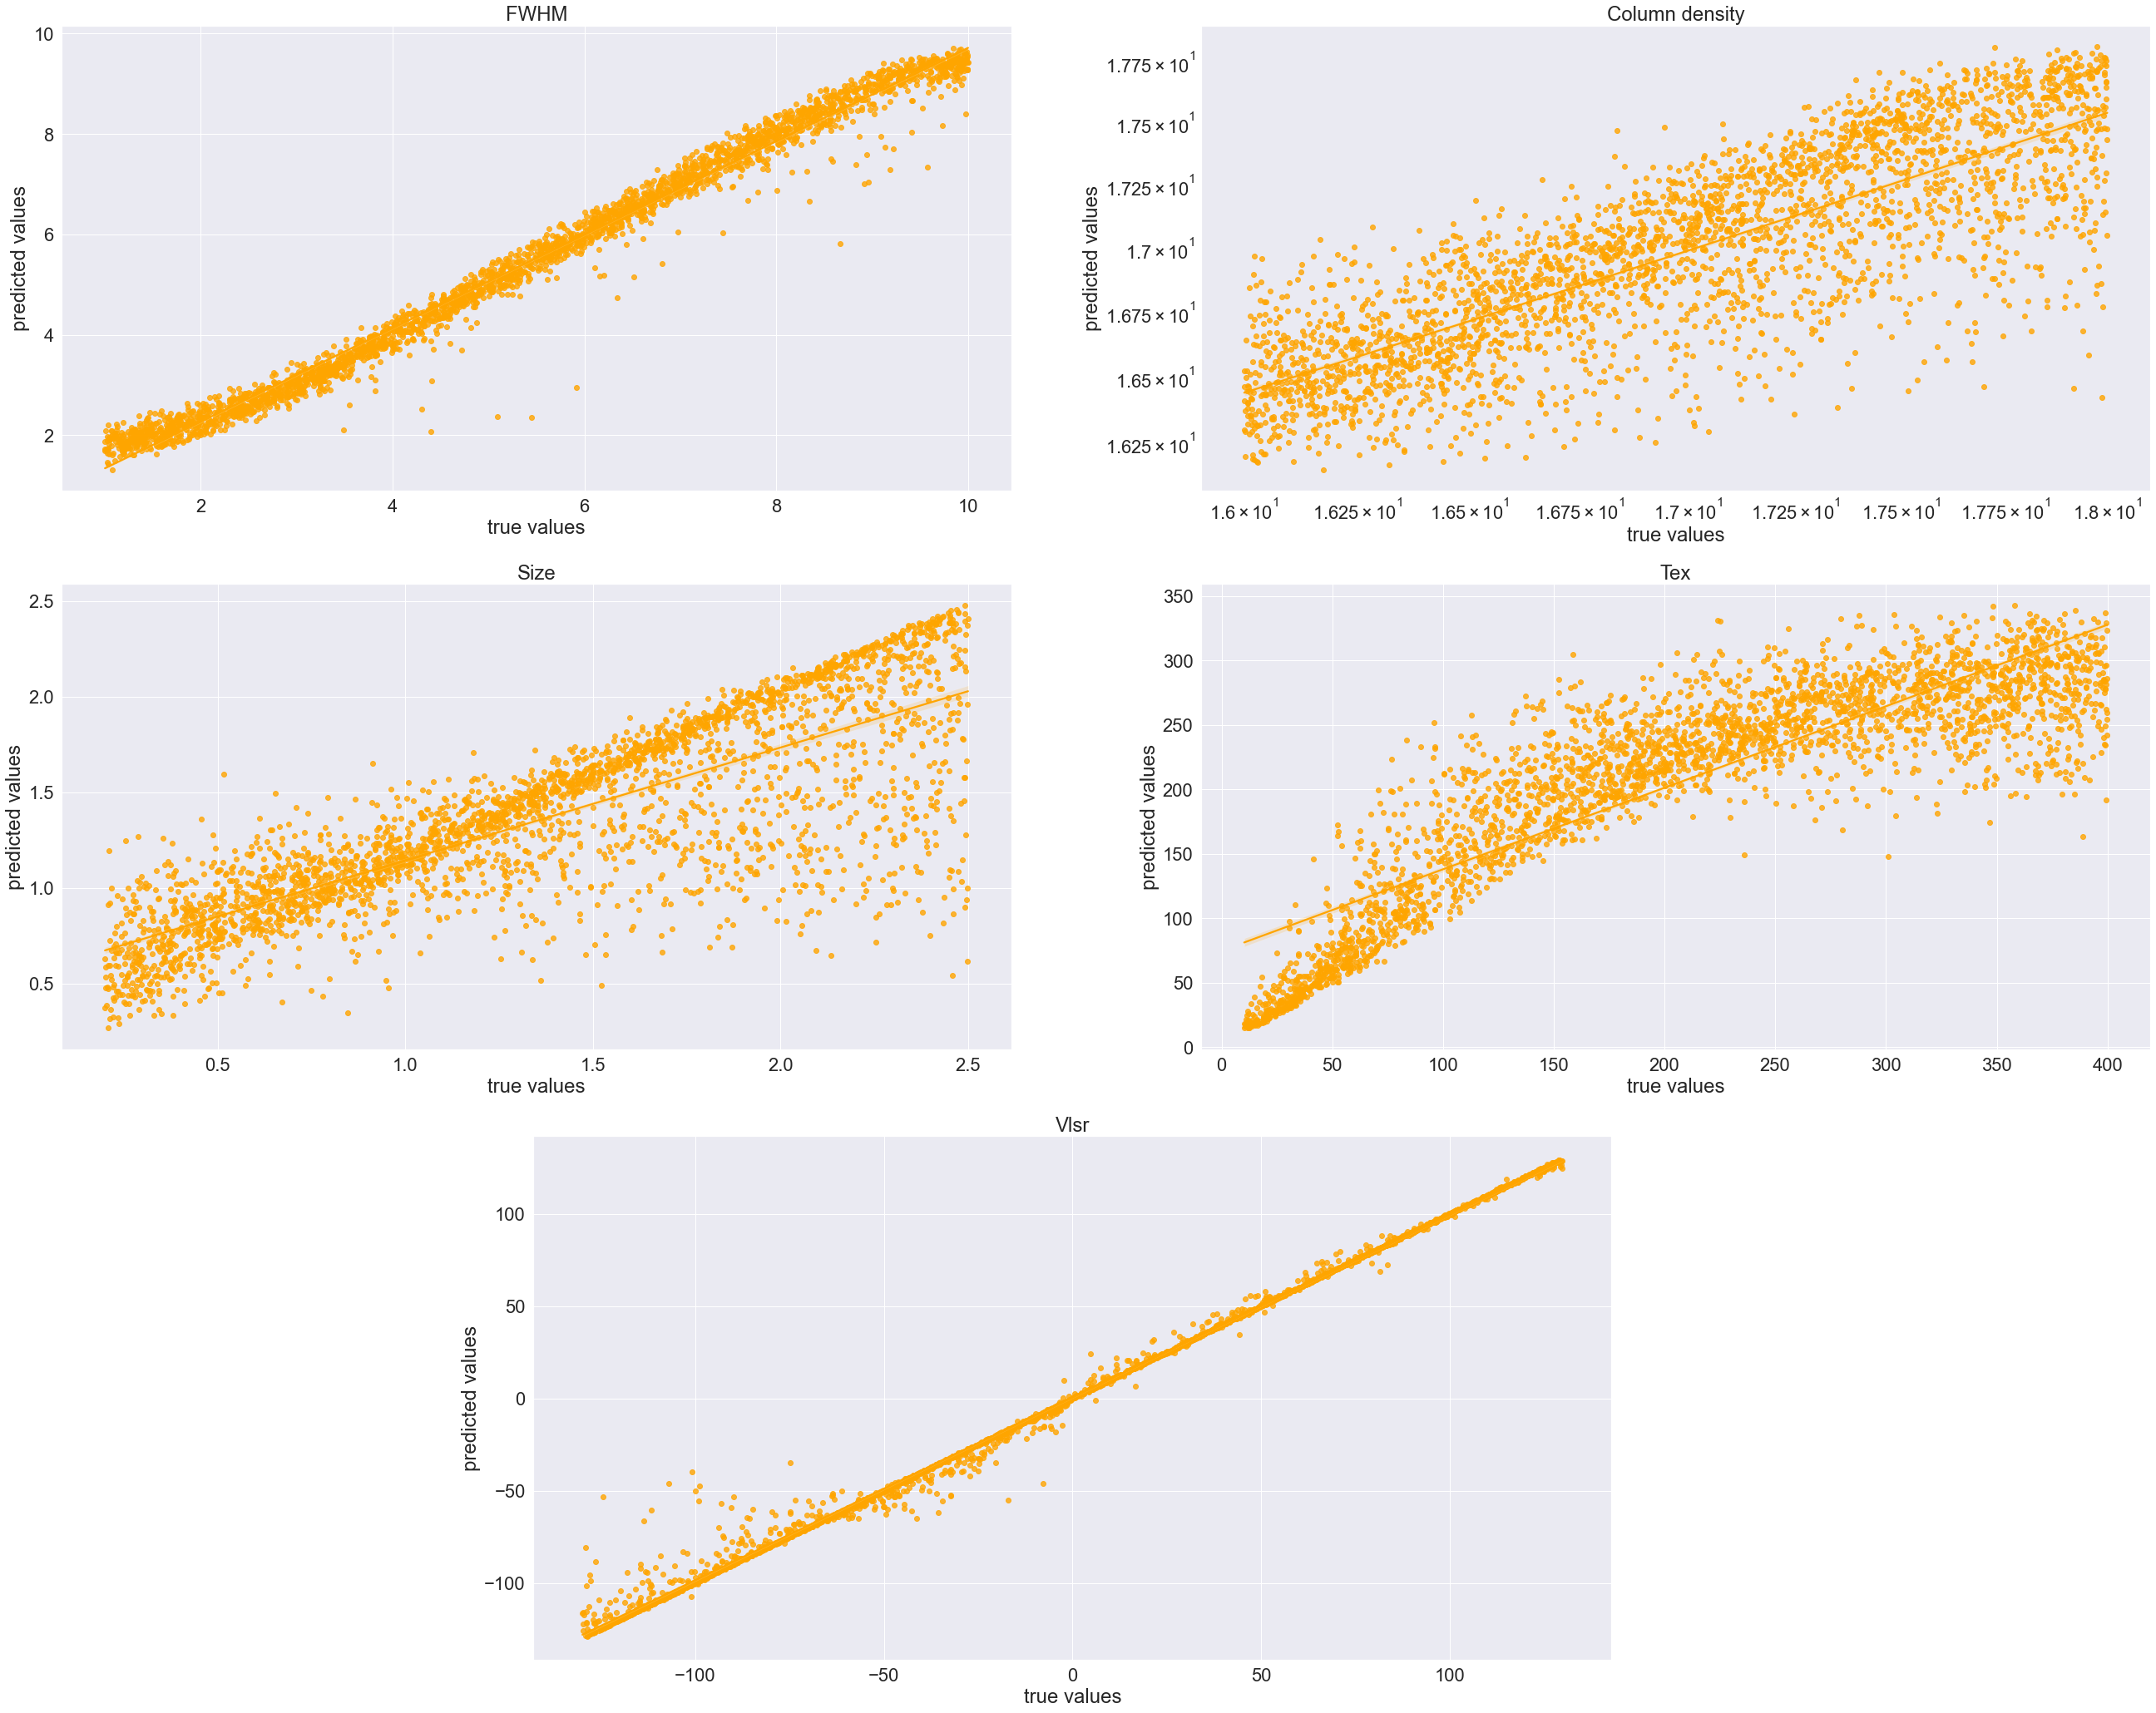

In [70]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_tuned_RF.png")
plt.show()

### Residuals - RF Tuned Model

In [71]:
residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
residuals_tuned_rf

fwhm      ntot      size         tex       vlsr
7000 -0.168309  0.012877 -0.170008    8.766353  -0.032085
7001 -0.065859  0.062341 -0.079157  -51.683726   0.115271
7002 -0.131527  0.180380 -0.134170  -18.788291  -0.597166
7003  2.846792  0.102244 -0.655404   -3.180015 -14.695748
7004  0.067817  0.199013 -0.320065    7.243952  -0.000273
...        ...       ...       ...         ...        ...
9995  0.088937  0.122724  0.051159   -9.396004   0.173174
9996 -0.058206 -0.164628  0.231860  103.603360  -4.860159
9997 -0.231734  0.128465  0.059264   59.120359   0.118565
9998  0.188267 -0.275241 -0.014707   -8.525130   0.245099
9999 -0.626723  0.640802 -0.114100  106.893706  -3.087645

[3000 rows x 5 columns]

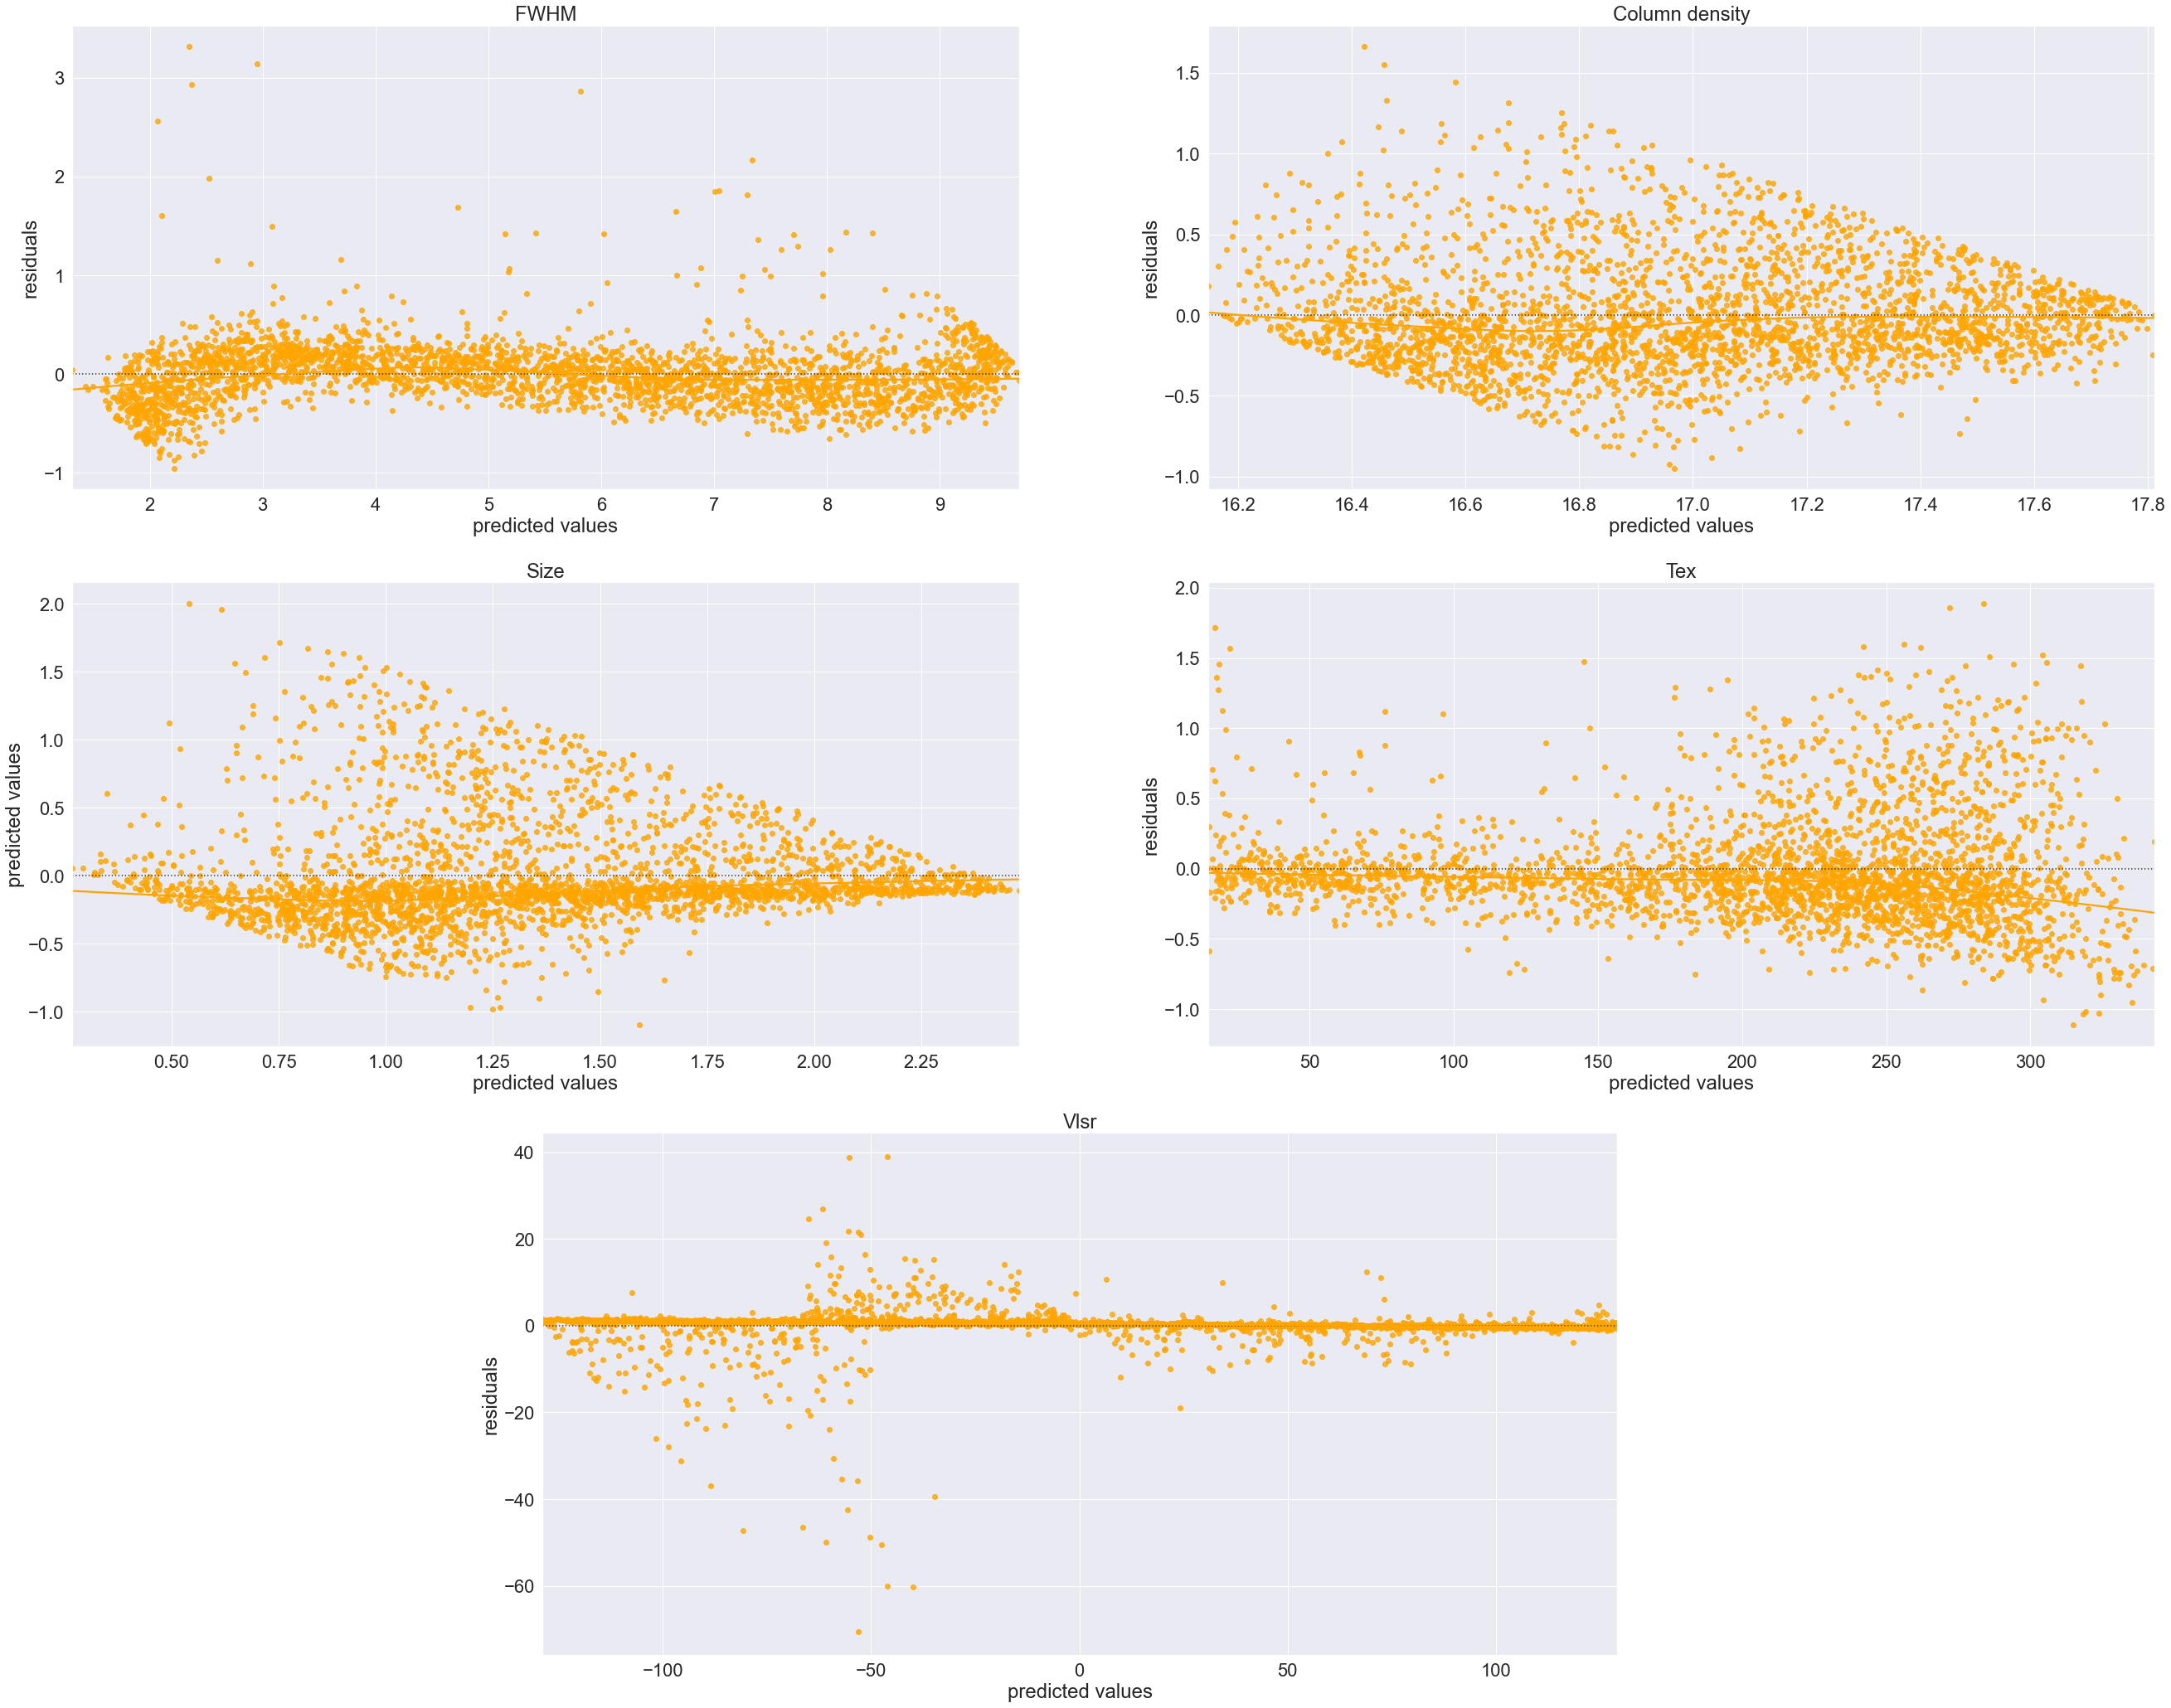

In [72]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_tuned_RF_10K.png")
plt.show()

## 2. XGBoost Regressor

In [73]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)

multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7fd0ceb4a820>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [74]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [75]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

mae : 9.588609892284206
mse : 744.5811166229264
rmse : 27.287013699247606
mape : fwhm     5.342504
ntot     1.671642
size    37.673195
tex     29.947020
vlsr    11.251091
dtype: float64
r2 : 0.7689850432971289
msle : 27.287013699247606


### save the predicted parameters to a csv file

In [76]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm_pred_xgb', 'ntot_pred_xgb', 'size_pred_xgb', 'tex_pred_xgb', 'vlsr_xgb_pred'])
param_df_xgb['ntot_pred_xgb'] = np.exp(param_df_xgb['ntot_pred_xgb'])
param_df_xgb.to_csv('data/10K_gen_files/predicted_parameters_xgb.csv')

In [77]:
param_df_xgb.head()

fwhm_pred_xgb  ntot_pred_xgb  size_pred_xgb  tex_pred_xgb  vlsr_xgb_pred
0       8.201745     41380432.0       1.353275    306.735168     100.321762
1       5.038821     41043764.0       1.739041    214.238953      60.119003
2       2.351633     33256200.0       1.803184    294.314545    -109.283379
3       6.562904     17254668.0       1.295563     41.466343    -102.327179
4       4.287548     20532758.0       0.692901    260.318878     -82.243668

### Predicted vs True values - XGB Regressor

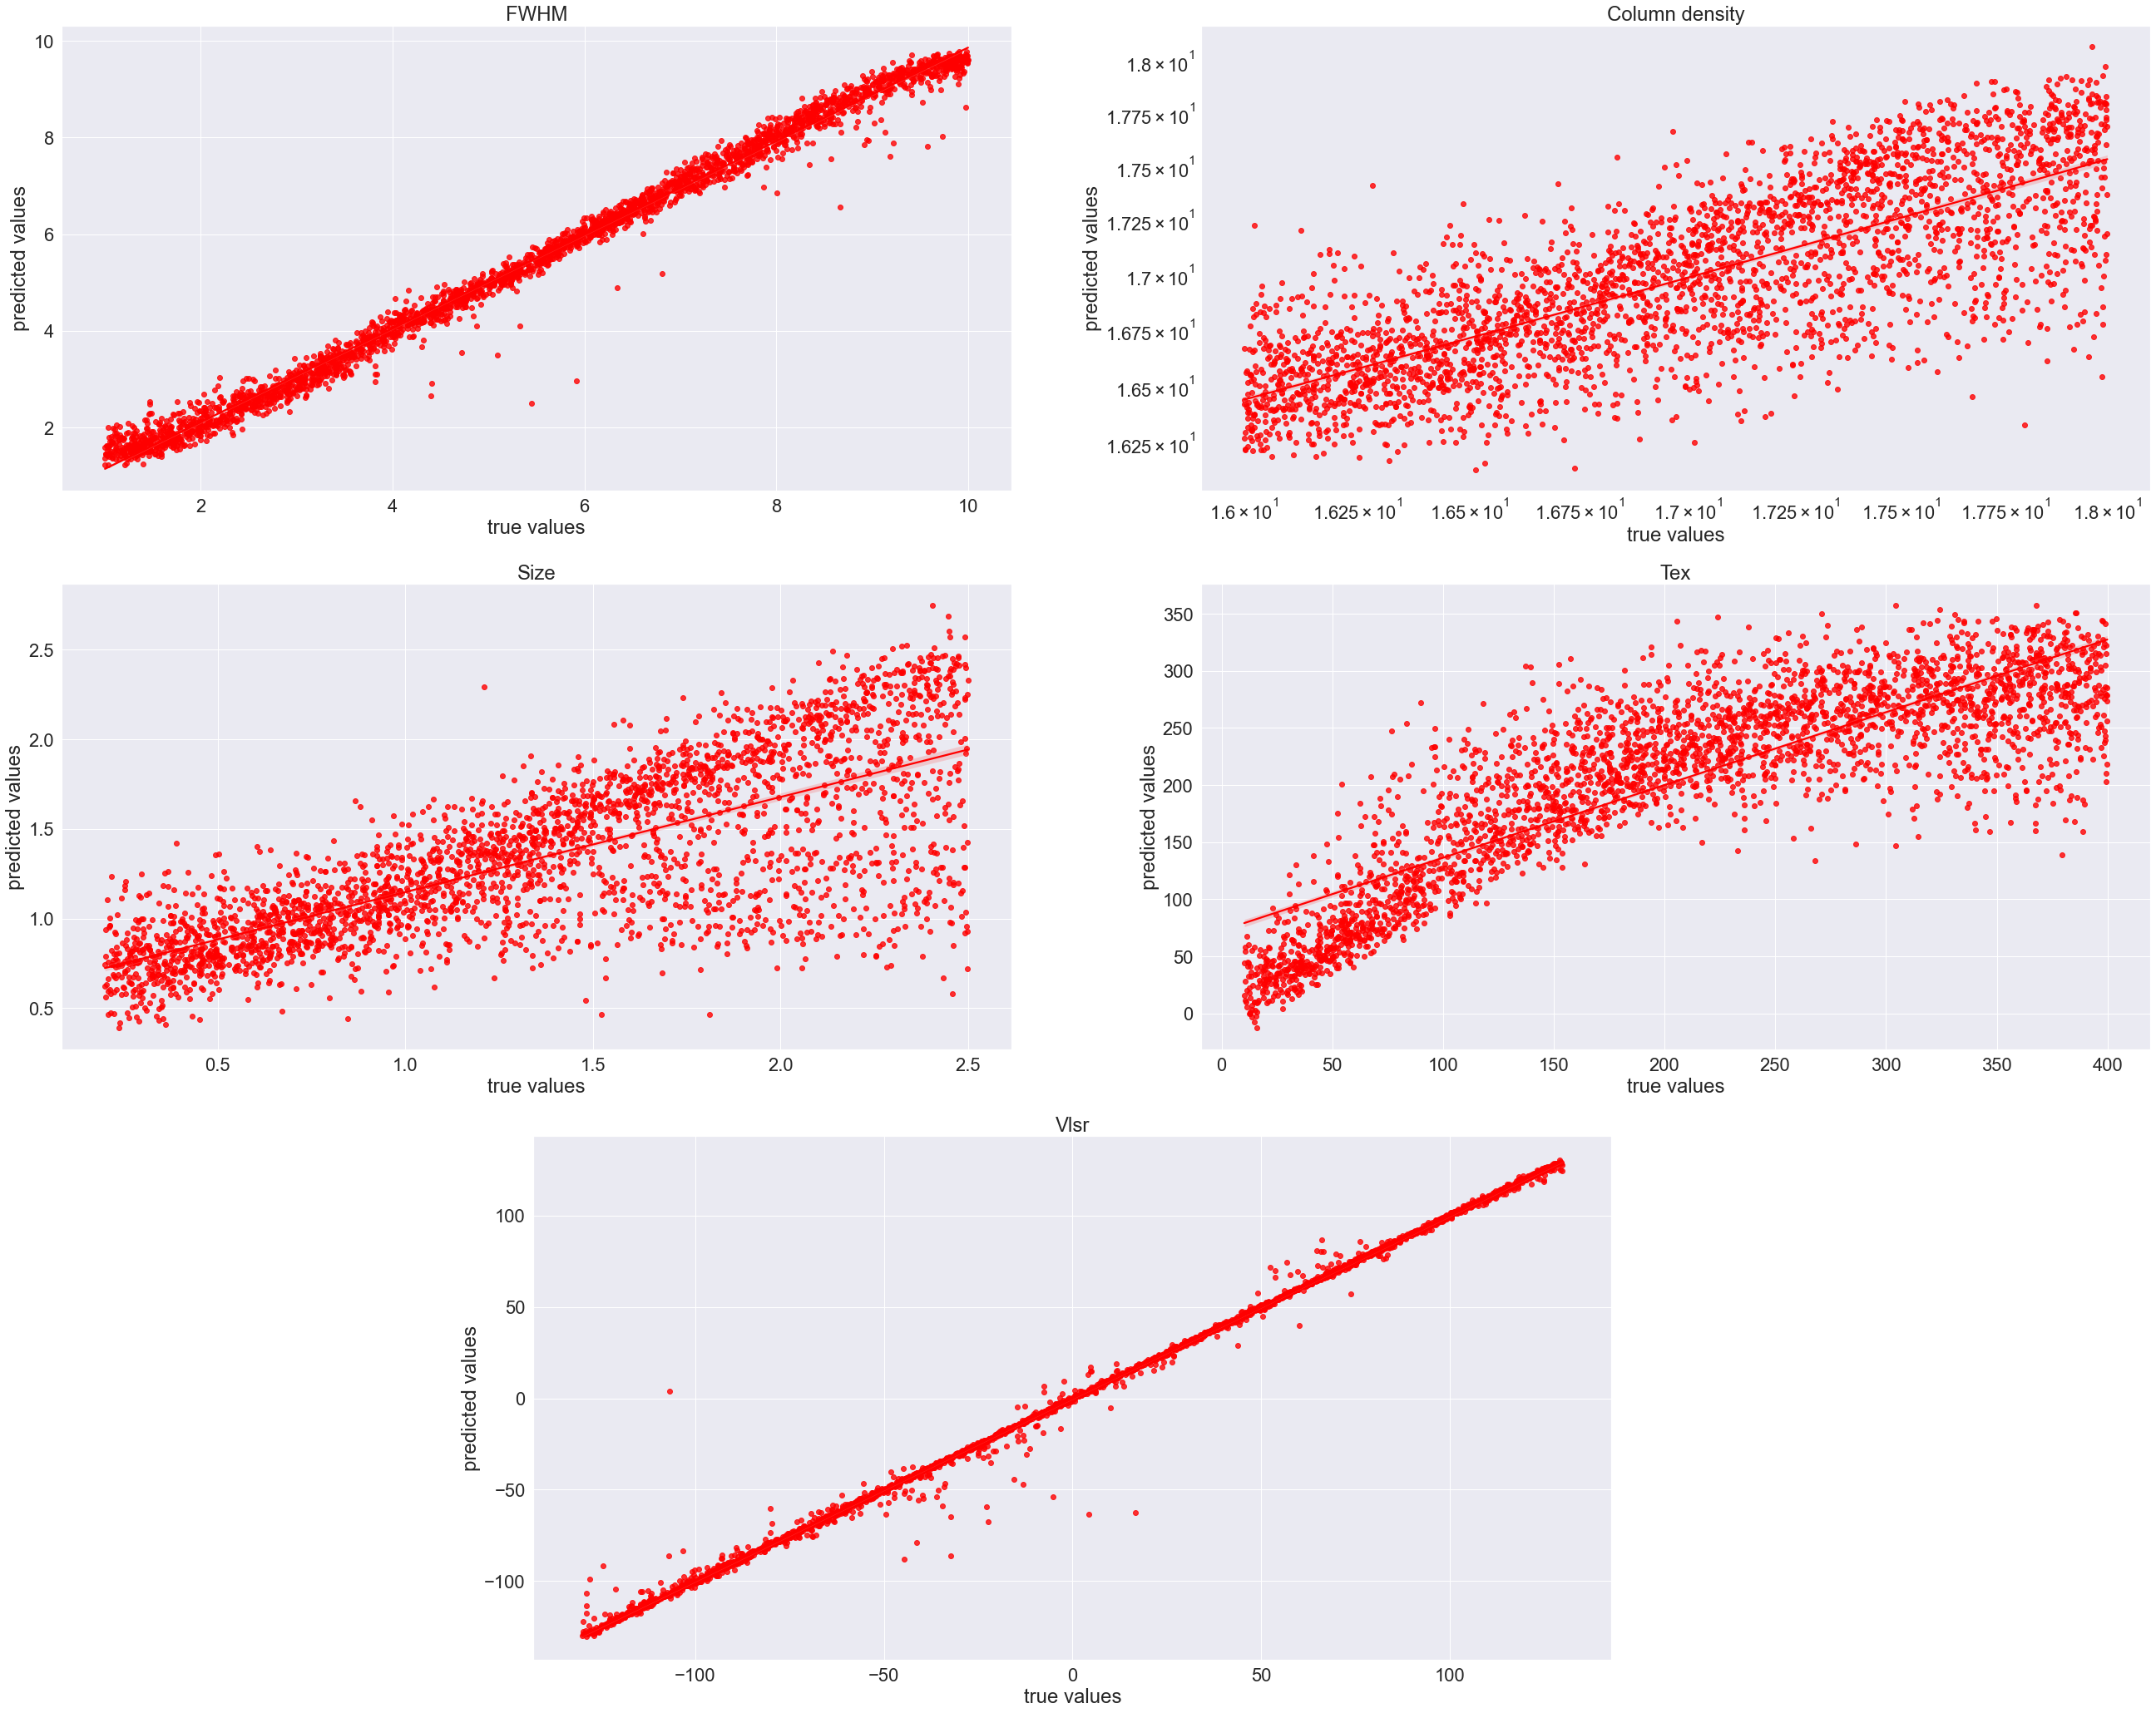

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_XGB.png")
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [79]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb.head()

fwhm       ntot      size         tex        vlsr
0  8.201745  17.538319  1.353275  306.735168  100.321762
1  5.038821  17.530149  1.739041  214.238953   60.119003
2  2.351633  17.319752  1.803184  294.314545 -109.283379
3  6.562904  16.663593  1.295563   41.466343 -102.327179
4  4.287548  16.837532  0.692901  260.318878  -82.243668

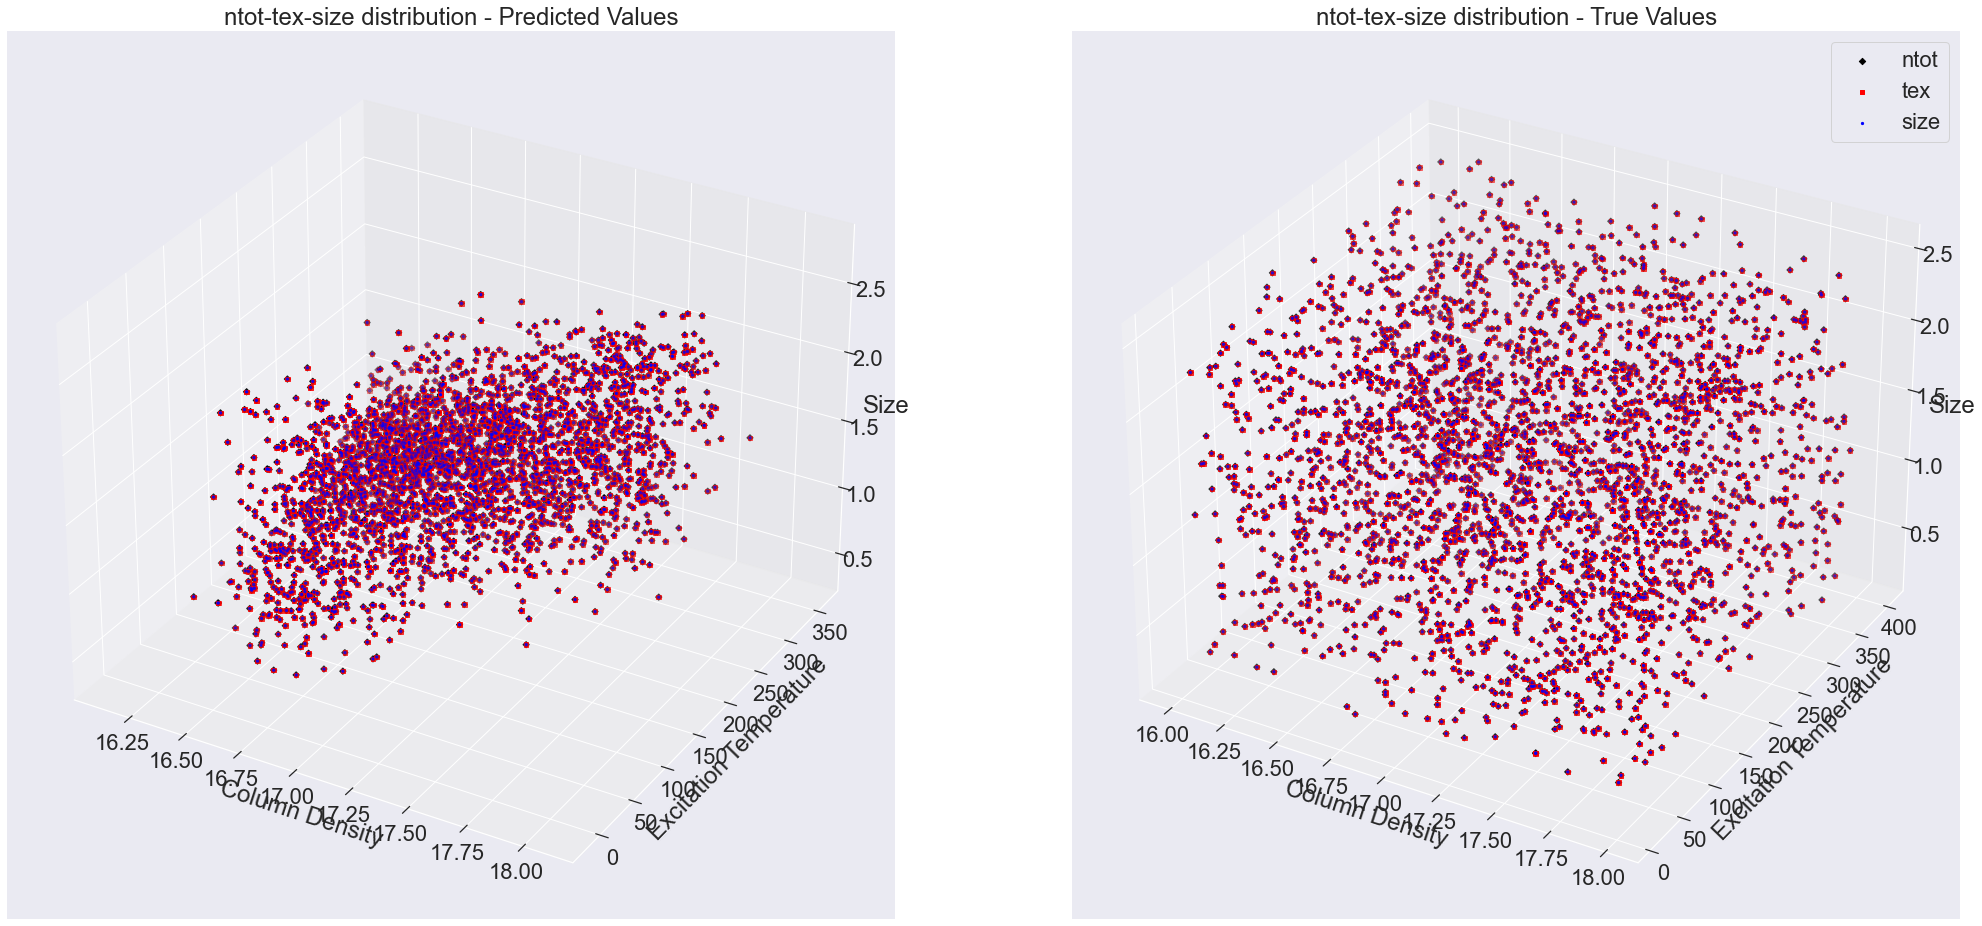

In [80]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/10K_gen_files/scatter3D_pred_true_10K_XGB.png")
plt.show()

### Residuals 3D plot - XGB Regressor

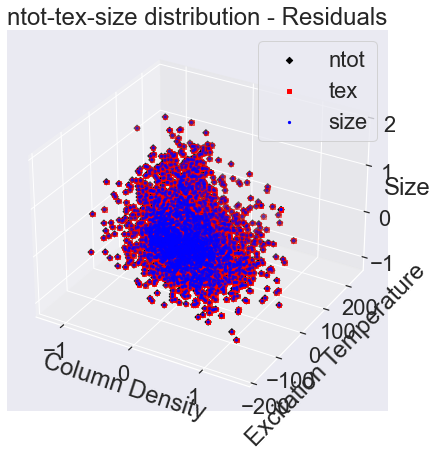

In [81]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

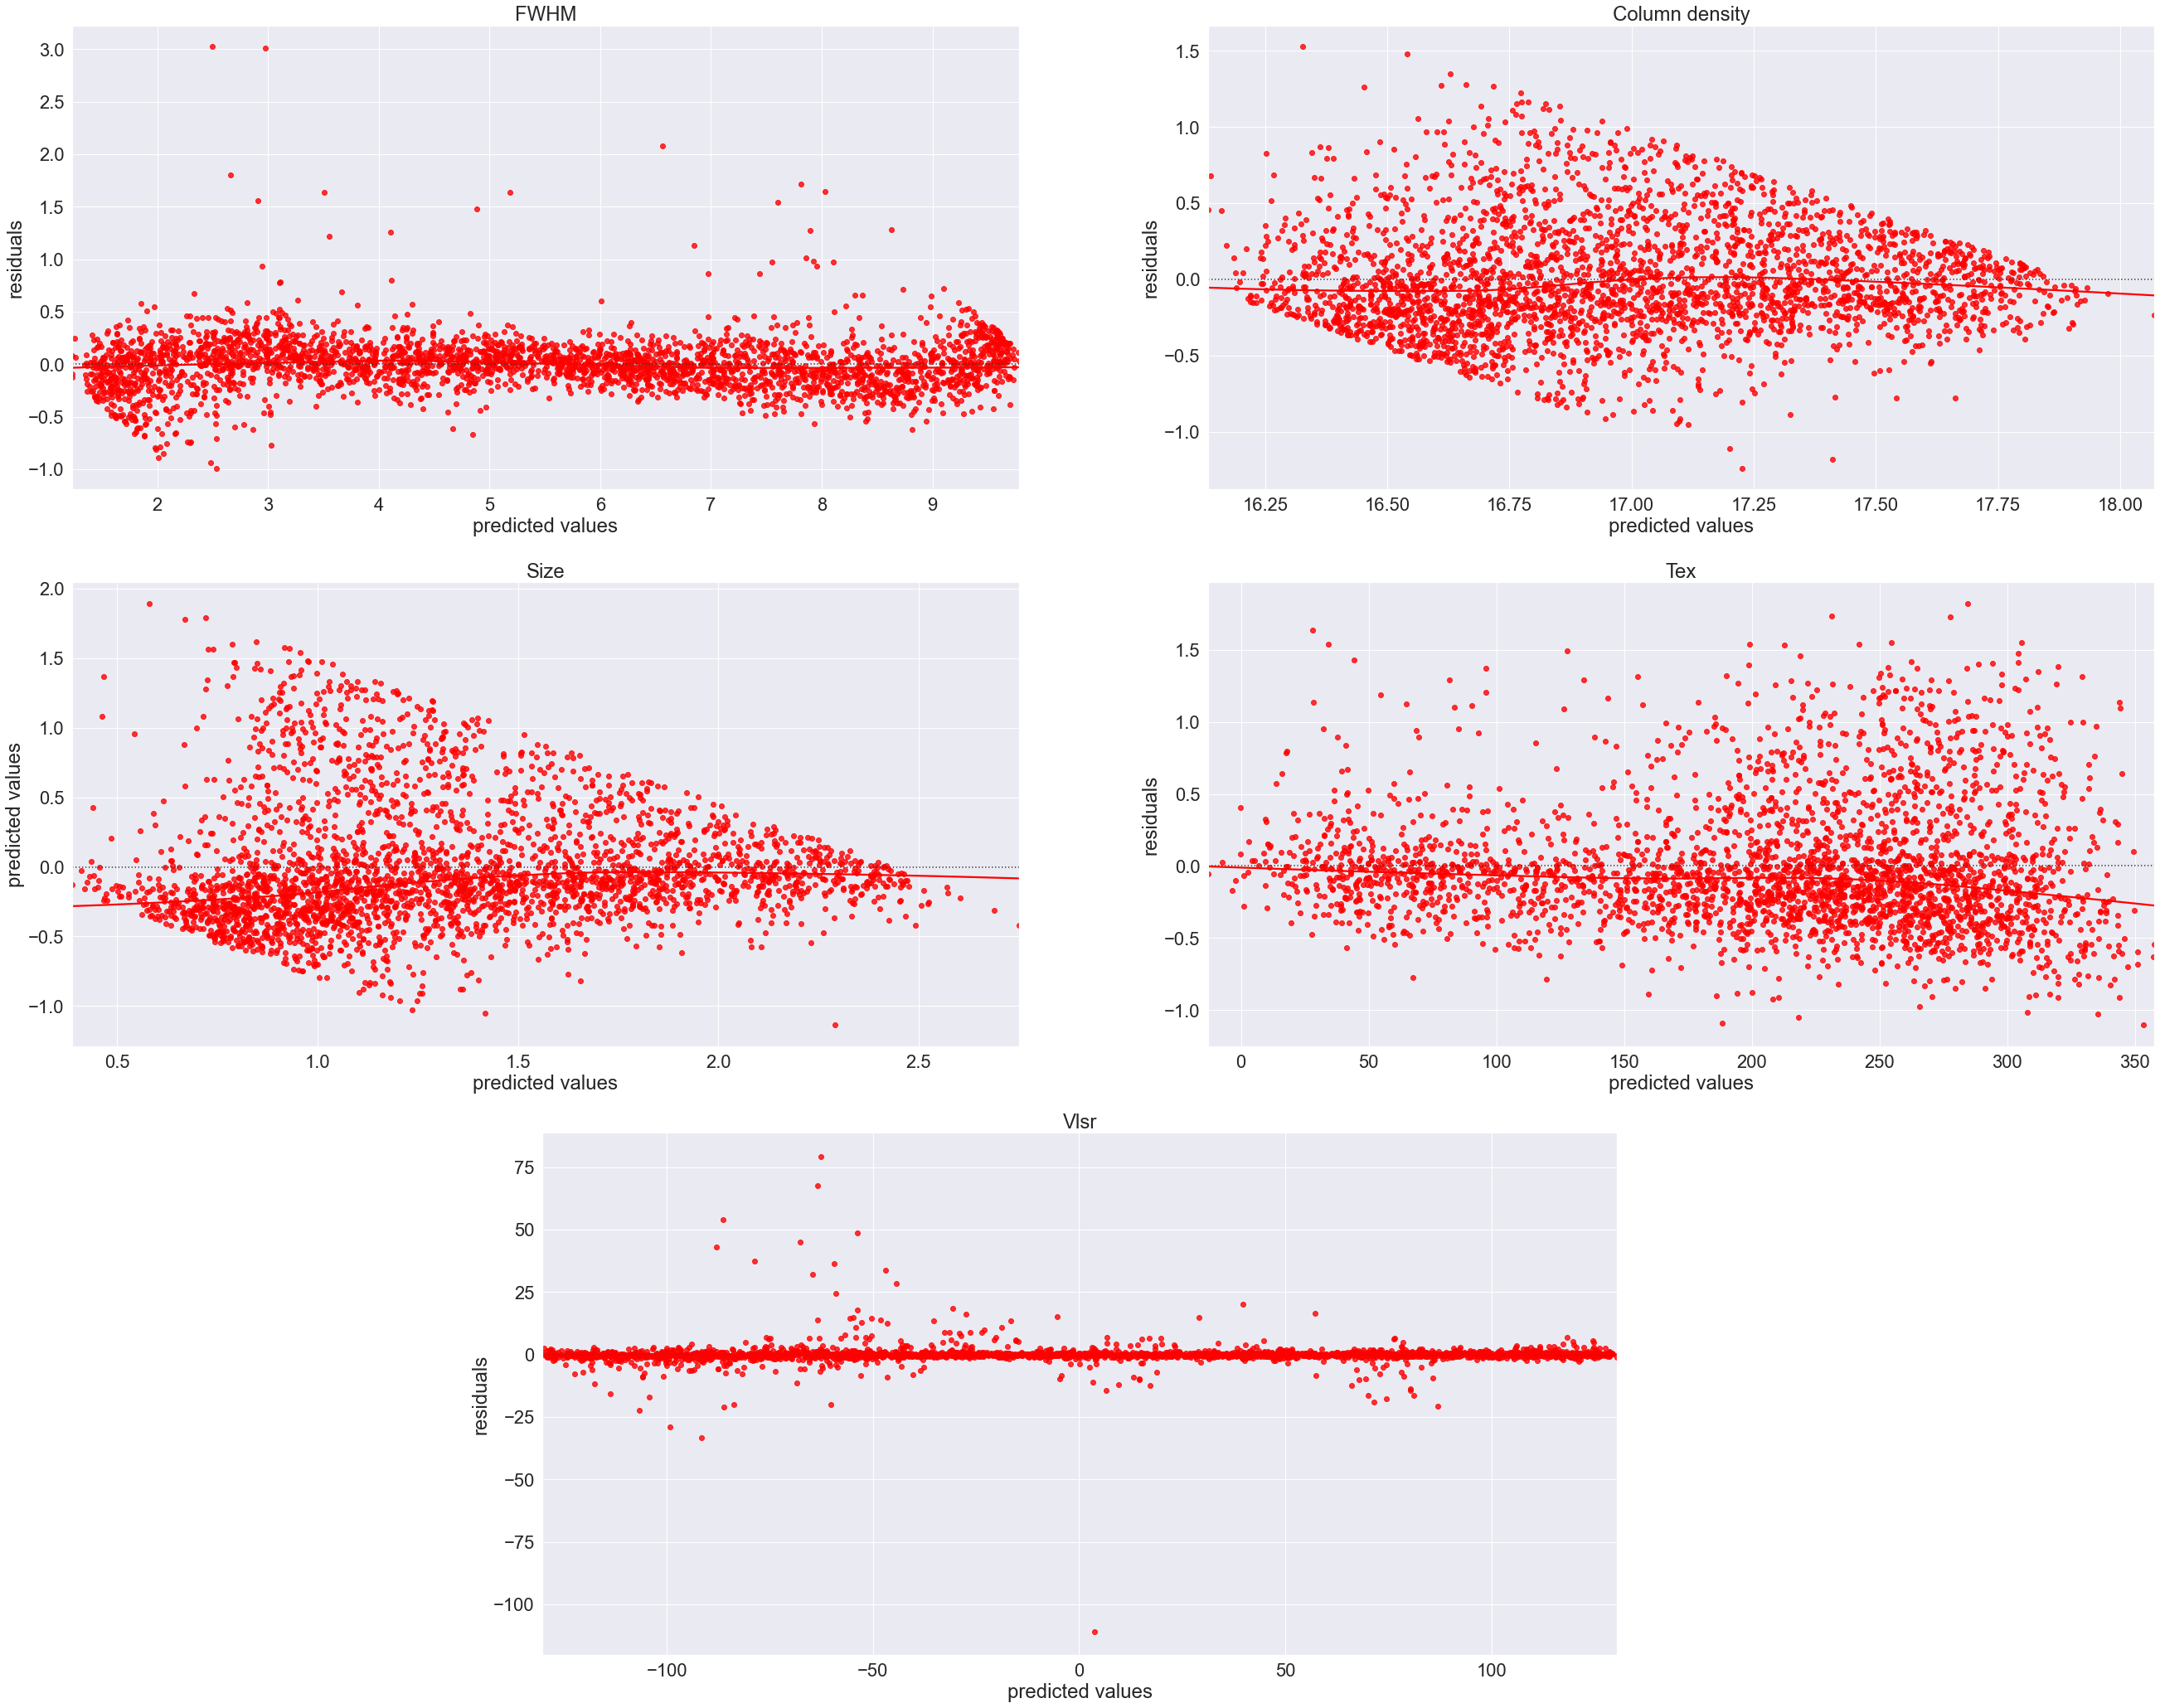

In [82]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_XGB_10K.png")
plt.show()